In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from utils.ShipDataset import get_ship_dataset, load_image
from utils.Training import TrainingHelper, PlotReporter, ConsoleReporter

In [2]:
n_samples = 10000
train_dataset, valid_dataset = get_ship_dataset("./dataset/class", n_samples, validation=0.2)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

### ResNet 
20 layer ResNet like architecture with a 3x3 kernel is size

In [6]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_size, out_size, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_size , out_size, 3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_size, out_size, 3, padding=1, stride=1)
        # this conv adjusts the dimensions and kernel size for the residual connecteions if the input size changes
        self.resampling = nn.Conv2d(in_size, out_size, stride, stride=stride) if in_size != out_size or stride != 1 else None
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        
        out = self.conv2(out)
        
        if self.resampling is not None:
            x = self.resampling(x)

        out += x  
        out = F.relu(out)
        
        return out
    
    
class ResNet20(nn.Module):
    def __init__(self):
        super(ResNet20, self).__init__()
        self.convs = nn.Sequential(
            ResidualBlock(3, 8),
            ResidualBlock(8, 8),
            
            ResidualBlock( 8,16, stride=2),
            ResidualBlock(16,16),
            
            ResidualBlock(16,32, stride=2),
            ResidualBlock(32,32),
            
            ResidualBlock(32,64, stride=2),
            ResidualBlock(64,64),
            
            ResidualBlock(64,64, stride=2),
            ResidualBlock(64,64),
        )
        self.fcs = nn.ModuleList([
            nn.Linear(5*5*64, 1)   
        ])
        

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.shape[0],-1)
        
        for fc in self.fcs:
            x = torch.sigmoid(fc(x))
            
        return x 
        

net = ResNet20()

In [7]:
# Test the forward pass of the network
inputs, lables = next(iter(train_loader))
x = net.forward(inputs)
print(inputs.shape, x.shape)

torch.Size([32, 3, 80, 80]) torch.Size([32, 1])


In [8]:
# Numper of parameters
sum([p.numel() for p in net.parameters()])

348425

In [75]:
training = TrainingHelper(net, nn.BCELoss(), optim.Adam(net.parameters(), lr=0.001))
training.reporter = PlotReporter(figsize=(15,5))
#training.reporter = ConsoleReporter()

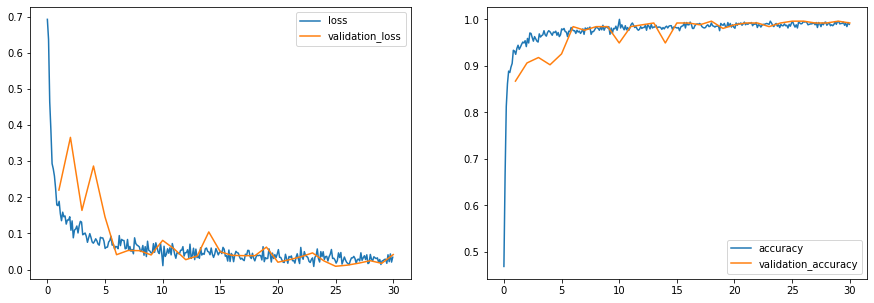

In [79]:
# train for n_gen generations
n_gen = 30
training.fit(n_gen,train_loader,valid_loader)

In [81]:
# calculate mean accuracy and loss of the last n validation epochs
n = 10
print("Acc: ", np.mean(training.reporter.val_acc[-n:]))
print("Loss:", np.mean(training.reporter.val_loss[-n:]))


Acc:  0.992578125
Loss: 0.02544226287136553


### Results
Resnet with 20 convolution layers (8/16/32/64/64) and a flat classification layer  
no overfitting  
fitted after 20 epochs  
Acc: 0.9926
Loss: 0.0244

In [ ]:
8/16/32/64/64: data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2oAAAEvCAYAAAA0ITL9AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdd3jUVdbA8e+dkt5JgJAQQgk1CQQCCEhTmiAodqxYYNfXupZdde2661pWsRfsFRFRUWBREAGRFjokQCAQSIEU0uuU+/4xSUhIAgmGJBPO53l4zPzmzm/OZOLMnDn3nqu01gghhBBCCCGEaD0MLR2AEEIIIYQQQoiaJFETQgghhBBCiFZGEjUhhBBCCCGEaGUkURNCCCGEEEKIVkYSNSGEEEIIIYRoZSRRE0IIIYQQQohWxtRSdxwYGKjDw8Nb6u6FEEI0o82bN2dprYNaOg5nIe+RQghxbjjV+2OLJWrh4eHExcW11N0LIYRoRkqp5JaOwZnIe6QQQpwbTvX+KFMfhRBCCCGEEKKVkURNCCGEEEIIIVoZSdSEEEIIIYQQopVpsTVqQghxOhaLhZSUFEpLS1s6FNFAbm5uhIaGYjabWzoUIYQQwqk1KFFTSk0CXgWMwPta6/+cdP0rwNiKix5Ae621X1MGKoQ496SkpODt7U14eDhKqZYOR5yG1prs7GxSUlLo2rVrS4cjhBBCOLXTJmpKKSPwJjAeSAE2KaUWaa3jK8dorf9WbfxdQMxZiFUIcY4pLS2VJM2JKKVo164dmZmZLR2KEEII4fQaskZtCLBfa52ktS4H5gGXnGL8DOCrpghOCCEkSXMu8nwJIYQQTaMhiVoIcKTa5ZSKY7UopboAXYFf/3xoQgjR8ry8vFo6BNGKKaU+VEplKKV21XO9Ukq9ppTar5TaoZQa2NwxCiGEcE5N3fXxGmCB1tpW15VKqdlKqTilVJxMjRFCCNEGfAxMOsX1FwERFf9mA283Q0xCCCHagIYkaqlA52qXQyuO1eUaTjHtUWv9ntY6VmsdGxQU1PAo63Ags5DP1ydTUl5nTiiEEE1Ka82DDz5IZGQkUVFRfP311wCkp6czatQoBgwYQGRkJGvWrMFmszFz5syqsa+88koLRy/OFq31auD4KYZcAnyqHdYDfkqp4OaJTrQFVpud1fvky20hzkUN6fq4CYhQSnXFkaBdA1x78iClVG/AH1jXpBHWY3NyDo9+v4vRPYPoHODRHHcphDiHLVy4kG3btrF9+3aysrIYPHgwo0aN4ssvv2TixIn885//xGazUVxczLZt20hNTWXXLsdsuNzc3BaOXrSg+pYPpJ88UCk1G0fVjbCwsGYJTrR+P+1I596vt7H47vPp18m3pcMRQjSj0yZqWmurUupOYBmO9vwfaq13K6WeBuK01osqhl4DzNNa67MX7gk+bo7Q80stzXF3QogW9tSPu4lPy2/Sc/bt5MMTU/s1aOzvv//OjBkzMBqNdOjQgdGjR7Np0yYGDx7MLbfcgsVi4dJLL2XAgAF069aNpKQk7rrrLqZMmcKECROaNG7RNmmt3wPeA4iNjW2W91LR+u1MzQMgKbNIErWzrbwI9i+HjD0w8Abw6dTSEZ1Vh7OL+Tn+KLeM6IrB8CcbQVlK4fgByNoHmfuwFWZgbEBzKQ1YbBqXgM5YAiIwd+gNfl3A2DxbPVvLy7BlJ+Gau5/C1HgoycUzuBcqqCcE9gLPds0SR30a9FvQWi8Blpx07PGTLj/ZdGGdnrebYzPVglJrc96tEELUMGrUKFavXs3ixYuZOXMm9913HzfeeCPbt29n2bJlvPPOO8yfP58PP/ywpUMVLaMxyweEqCUh3fEF1eHjxS0cScux2OzkFJXT3seNtNwSgn3dUEqxJjGTPekFzBrV7cxPXpQN+5bCnsVw4FewljqO//E6jHsCYm8Bg7FRpzxeVI672Yi7S+NuV+lQVhELt6Rw5wURuJhqrlLSWpNRUEYHH7eqY6UWGwWlVoK8XRt1P3OW72Ph1lTcXYxcN7RLw25UfNyRjGXtg8y9kJXo+Dk3GbS9aliB9sLdxYRrtfg1UGKx4WI0YKpIDEstNiwWCy6qGHPlOKMLKqA7BEZAYE8I6uX4uV0EuHphtdnJKiyno68bKTnFhPi51+o4/MeBLJbsTOemYeFEdPDGVpxLYdoefAuTKuJPhMy9qOwkXHEso/ICyrQJpU7kFjY3f46aw+jYvT/G9j0hsCfFPt0p8wzB39u9Ub/vM9E86epZ4F1RUZNETYhzQ0MrX2fLyJEjeffdd7nppps4fvw4q1ev5sUXXyQ5OZnQ0FBmzZpFWVkZW7ZsYfLkybi4uHD55ZfTq1cvrr/++haNXbSoRcCdSql5wFAgT2tda9qjEHXRWhNfkaglZxc1+Hbbj+Ty2fpknpjat+qL7TO4cyg8VvFhvOKD7fEkGHwr9LrozM55qvta/gQc2Vjn1cdyijmWX4ZXsA+paXkYAzxo7+dNboo7R0uCOGAeT/feMeDbGQy1E5sth3OJCvE9kfTkHnYkZgk/weE/HAmGTygMmsnh9hfw+a5S/qE/wLjkAdjxNUx9FTrUfA/ad6yAYF83vN3MlFltJB4rJDLEF6010974nZERgTw6pS/peaX0aF+ze/DiHensOZrP38b1ZMvhHDoHeDBneSITurkx0v84P3yzBI/cA2QlFeJHIa4mI1mFZRSVWbHaNXklFjyDffByNaGB5GMFlJbbCOzSDtVlBPS+GDpGwUnJi92u2Z6SS4i/Ox4uJpbuOopBwXNL9jCuT4eq5C+v2EJOcTnhgZ6O5zzhJ0j8GTISoDjrxAmNro4EqtMAiL4aAiM47h7OlC/SSS810CfAh6X3jKwa/ntiJjd8sBEXk4FnLulHzw7eXPnOOiJDfPFThQzyzOZI4jbG++cxPiAfju2GPT/VSACL3Dpy3BhERqEFn2Af0tPysHq70qWdJ7nF5RSUWvF2M2HKKGQaYNpjQpuyMRYepaoebTBBQHdK/SP4MKMfibZgsty7cESF0s7fj7Lsw7w+3ovS9Hj27tpMcPERAhN+wrjNsRzZAzBixhYUgXHIrTD4tvr/tv8kJ07UKitqMvVRCHH2TZ8+nXXr1tG/f3+UUrzwwgt07NiRTz75hBdffBGz2YyXlxeffvopqamp3HzzzdjtjjeX5557roWjF2eLUuorYAwQqJRKAZ4AxxfDWut3cMxGmQzsB4qBm1smUuGMjuaXklvs+JyTnN2witrh7GJu+XgT2UXlhPi587fxPU99A5sFcg7VTMiyKiolZdWmm7t4gdEMR3dA+Png6n2Gj6oOe36Cta9Cp5ha57VrSC+0U243kl5oo1ybSM6z4GLI43zLFqaaC2HZ544FOiZ3COxBvlc3/sgNIMHi+AC+4JArF3Uq4tneh/FKWup4DABBfWDk/dB7CgQPAKWY8/U2FiakEn7p61wbsx6WPQzvjoLhd8Hof4DZHZtdM/3NtXRv78W82efx1KJ45m8+wvL7RmOza1JySvh59zEAvtuaysZ/jsOnMmG22/lh1XpK0vewMLGA0vQ9WFQ69xlSCdrhmOZ6D2AxGjl8tBOHbN6YTUbKrfaqvEthIr3QhjXPik1r8oo1YKCsuBC3VS/AqufBLwx6TyW783iWF4aTmm9h4ZYUUnJKMBoUvTp4U2Kx8dKV/Xno2x288et+nrk0kq3Jx3n5swUMs6znL0HxGLMSACht1xdbt4l4durLIRXC6zsN/O3yCwht53i+juaVkpZXwh/7s0gvOcaNw7rw6bpk4tPy6dvJBzgxjXdgmB//+Han4ynwduXjmwfj5+ECwH9/HsSsX/fz6ugBbPHIYUN5Ol7FRwgsTaaHIY2I4jTak4NdG0nJt1KuTaTm23Bzs3Msz0JhmQ1jgQ0XsyvebiaOFpSR6T+AlRY/9utOTB8/hsmjhoPRzFs/7+X13ftp5+lCVmE594/vyYiIQC57K5+xPwBE4+kSg6vZSDtXF7Lz07kjSnNoz1Y621MYWXqcPoYz/CKkgVQzLSmrJTY2VsfFxZ3x7bMKy4h9djlPTevHTcPDmy4wIUSrkZCQQJ8+fVo6DNFIdT1vSqnNWuvYFgrJ6fzZ90jRemxIysbXw0zvjj6Nvu2KhGPc+kkcYQEelFlthAV4cPnAUK4ZUn+zmbu/2sqvezLo28mH+LR81vx9LP6eLlCaD9mJVVO+qqavHU8C+4nZSdo7mB0lQbgG96F3ZCyf7XfhrV1Gfnj4Ctrnx8P7F3A0+nZyhj1Cn+DGPSatNWVWOyaDwmSsqG5ZSuGtoY4k66+/11qb9NveDGZ+tAkAN7MBm11jsWkMyvEhf9ZAH5atWsPbE70ILE2mKC2B3MM7CdZZGFQdn3FDh0Cfix1Vp3bd2XesgAe/2c5FUcFcf14XBj+7nBKLjZ4dvFh27yhU8XH45THY9gX4h8PFr3DQdyhjX/oNgG5BniRlOqqdd4ztTpCXK0/+GA+A0aCw2TWPXBBM5pZF3N4hAf/031HlhVXhFCkvcjy7UuzTjW+TPdivO9G1dwzhPfry6KI9RIX4ciy/lF4dvXn7+kHY7JonftjF99vSAPB0MdLJz53EjEJmj+rGhl17uM4vnktct2BOXo3BXk6W9mG5bSApHS6g+9CL2Ztt4dstKbTzdGHpPSN59LvtHNqynDdi0ijduYhgMrFpRZJHNCv0YM6fehPXf3sUk8HAvNlD+b8vtrDvWCHn9wjk4uhghncP5NnF8azcm0GApwvh7Tx55/pBDPn3cq4dEkavjj58uyWFQC8XEtILWPnAGD5fn0xhmZUrB4XSvto0zrwSCyOf/5X8UisuJgMjewTi62Hmwt4diAnzY/Jraygus2Gx2zEohY+bia6Bnhw+XkxWYTmuJgNlVjtvXBtDiJ8709/6o+q5WbrzKDatUcC4Ph34bH0yo3sGcX5EIC8t28vKB8bQzsuV99ckATC0aztC/N15d/UB3l2VVOM57d/Zj31HC/jtwTE1pqGeiVO9PzpxRa1y6qNU1IQQQghxGjYL2MrBxbPpz20th4K0Woftds2zn6+lSztP3rg2BnCs0XF3c6fErQOuJkOdTRwWbU8jxM+d3RUNlCb268DcNQc5ll9Gak4JVwwKZdnuYzzzUzw/3zeqqlqTX2ph/e793NeriCmd9vG/lNXkvvsCfjoNVT0+gwm7f1cMQb0c1aTAXry6Hd5PMPHolKH849udqP0wd1gsn2XsIV0Xsiw+gxvOG0Rh7ysJ2D6Xu/dE8eU/ZpxIuOpwvKicLzckM2NIGKv2ZfLaikQOZRcT6OXKqgfH4OlqgvVvOSp6N/5QI0mz2zWfrDvEe6uT8HU34242cjS/lBE92jE5KpikzCIu6N2esAAPnv0tk0Wmvtw0IZxL5qwm11TO97NiCNXp2I7twZhzgOVH4OHdoXw4aSpRoY5JcEmZhUx/cy3FFhu70vI5lFVEicXGjCGd+WrjEW74YCN/n9SLoxGPk1IwlMmH/kPHz6ZjD55CAFO5anQMq/Zl0q+TDz5uZr7bkkrfTj4EerliKkpnnNrMJJc4hq6Nx6xsHD8SQHaPqbyy252ALv34Iy+Qt2dPJNTXsdbp6Lyt2EosPDBjEEqBXRmZGt0JLzcTRqWq/lYuHxTK99vSuGRAJ166sj8AQ/61nLlrkjAb3XgsfyDfhI4lVd/IRe67uKvTXq4+8isq+zdY/gL0GMffp16M3eyB+uFOnklcisGUTdkOM5vtkRSNuJ8XDnbl52TH2q0OP2SQW2zBbFSMe3k1AFOig1m8I53f92cxJDyA7Sm5WGyaY/ll3D+hF/6eLlw6IISvNh3B3Wwkr8SC0aCY1K8jRoOqt8ji627mzesGkpxdzMXRwVWVtkof3zyE40VlvLhsHwnp+cSGBzA9JoT/+2ILAF/cNpTEjEImRwajFJzfI5DOAe7cP74XHi4mXly2F38PM+//fpAu7Tx47rIoAjxduCq2M25mx5rC20bWXPN4zeAwvt2cwkWRwXy2PhkXo4GPZw6moNT6p5O003HaRM3VZMTFZJA1akIIIYSoV1GZlTKrnYClt0P8D9B1pKOa0nsKeHds1Lm+3HCYAE8XJkV2hLICSPwF9vyEfd/PGMoLao03AD8CZAKvOo5Vth/4SF1N2fAHak1NPJZfyn1fbyMmzA+z0UCfYJ+qqWMGBWl5pSzbfYzvtqZyNL+UtYlZ9O/sRwcfN9b8sY7lxrvwOVACB+Bqswd784JZbOiJJWAy08ePhcCeHNYdmPLWeu4b2JPpMSFsTs7h1T1x2IG5aw4CEOrvzuM/7CItz9FcY8HmFHal5JF0+CI+ZhG3lnzIiz8PdEylU4pxfTswJSqYUosNu9ZkFpRx/fsbSMsrZXlCBjtScunXyZeZw8P5+I9D/BJ/jITEffwt4XmOBo7Br+NwPG12MgrKCPZx4/YvNrNs9zGGdg3g3nE9+Xx9Mot3pjOgs1+txhfdgzxZuTeDsAAP9mcU8vqMGEI7BAKBGDtGATC01ILl4ErumbeVt64fSER7bx5auBOjQbH4rpHc+OFG5m06wrBu7XjmkkhC/Nz5dF0yl731B1a7xtu1I194vMylBfO4Pf1HVriuwq3dczx09w2gFD9uT+OVeYuJKIzjcZ8dhLk6qmpZLqF8UDyZ3T4j+el4J4YVBfGHLZsN11zIfd6uNZpgzLl6QI3LNw4Lr/Pv8Pwegbx6zQDG9m6PuSJRjg0P4Jf4Y1wxKJS+wT48+v0uXIwuzLj9bvzaezu+TDi02rHebO8SDPHfOzZTdvXF0HMiu3zO55pfvYjuFsKXk87jtoPHyViSQIi/O4t3pNPBx5WPZg5h1b5MugV5Mr5PBy7s3Z7NyTl8seEwALee35VNh44zOcqxVeTdF0bw/bZU8koseLgYKS63ERly+s6lIyOCGBlR93UDOvsBsGpvJgnp+QwO92dC3w6E+Lnj72kmNjyA2PCAqvGf3za06udbz+9KqL87E/t1ZEVCBgPC/Gjn5WjAUpmk1aVroCdxj46n3Gpnyc50+oX44u/p4qhUn2VOm6iBo0V/viRqQgghxDktu7AMm13XmEJV6eGFO0k6sIcfbQtRoYMd1ZvF9zn+hQ52JG19pkK77jVut+5ANgu3pHDXBRE8v2wPkZ18+WDZBma2S4DteyDpN7CVY/cI5Ifywfxh6YGr2cx1Q8PIK7HwTVwKXq4mCsscn1MiOniReKwQf08zg0vX8RfDfJ7bP4yVYX5sOnicv0/qzdbDOSzddRSrXbM5OQeT0cAN53UhLMBRBZwxJIw1iVm8vWo/BzIc0+0+XHuQrYdzeXBcNy74435QRvR136I69ONYuTdXvLIaF6OBojQbYR7DGBQUwMc/xlNQauU/S/fw2opEcoodH6TdzUb2ZxTS3tuVByb04p552wAYGRHImsQs9h0tIDywPUfCb2di/Bw+WbOIfR6DMChHFXBLcg4bDh7neJGjK2FRuY0ZQ8L4auNh2nu78vltQ/FyNfHj9jSeWLSbRy2vYzBZuSl1GseeW4Gvu5nswnJevDKaZbuPcc+FEdw7LgKlFLvT8li8M52Yzv61nuOxvdrz6TrHVLpgXzdHIn0Sbzcz714/iDu+3MKkOWvw8zCTW2zhhcuj6dvJh6//ch65xRYGhvmhlOLOCyK4bmgXnli0m2A/Nx6Y0AuTQTHoWROLiofzX7cPiF5yF8TPh9DBXLxnMVNd9wJQ5BlN7oCHKAifSLFPD9Yt3cOLV0aT9NEm/jiQTYife52VmJM7F9ZHKcUlA0JqHBvevR0rEo5x8/Bwugd5EZ+ez4BQP3q0r1jzZ3KBHuMc/6a8DKlxYCmGsOFgciESmNc3j1B/x1cJQ7oG8P0dI0jJKWbZrqNcPjCUvp1OfGkAcNnAUEb1DOKbuBR83E08MrkPxmoV4s4BHjwwoRe5JRYKS618tj6ZqAYkag0xrHsgn6xLZli3QExGA5/dOgSTof7qLjiSscrf25To4Ebfp4vJwLzZ5+Hl1nzpk9OuUQMY+9Jv9OvkwxvXDmyiqIQQrYmsUXNOskbtz5M1aqdXZrVx55dbGdDZj4//OISvu5lf/jaqxoddi81OzNO/cLvtc243/YTh3u2OzoCZexyVhT0/Qvp2x+Cg3tD7Yt5I701gxBDiDueyYHMK3UxZjNUbmGDcTKzai1FptF8YqvdU6D2FV/YF8OqvSfznsig+XZdMYkYBnf09SMpyJFKBXq5kFZYBjimMz18ezX9/jOOOvTOxa/h3l/dZvLeA92+M5dZPHM955wB3jhwvAeCDm2IZ0SOQx3/YxZ1jI1iXlFXViKH6uR9yXcBf1UJWRr/I2MtmV/0OkrOL8HI1MXHOGjoHuPPBTYMZ/cJKBoT5sTM1j44+btw3vifd23sxZ3kiP25PY2K/Drw+YyDnP/8rJRYbS+8ZyZzlifx1dHdHB0NLKSVzBlFgd8Hz7nW4u7ryyHc7mbfJsbd75Tqhl6/qz7T+nfj3kj1MiuzIkK6OSsfDC3ewe9NvLHJ9DD3iXvZE3s+n65I5mlfCqn2ZeLqaKLXYiHt0PL7ujmmdR/NK+e/Pe3nqkn54uNT8oLzx4HGuened49wX9eYvo2sm3dVlFZbx1YbDJGYUcnF0MOP7dmhwggQw+9M4fo4/xqgeAXzaPx6WP+nYfy18BPSeCr0ng29onbfNLizjlo83ERsewGMX923wfTZEudXOkZxiugd5nX5wIx3ILCTEz73eqtMnfxzC3cXIVbGd67weHE1uXv81kWcujTxl9aqhtNYkZhTSs0MTNrVpIad6f3TqRG3aG7/j7+HCJ7cMaaKohBCtiSRqzkkStT/vXEzUtNaN+sC85XAOl1U0ClDK0eF94f8NZ2DYiYrLugPZzJy7mo3ud7Pe2pOMKR9yVWworiYjm5OPozXE+hU5WrXv+QmdvBal7WQagthq6k9YeSK9SQYg0yOCbZ4jeCWlJx/842aC/TzIyC/lgv+uYmREIG9fP4jswjLGvbyKnGILk6M6smTnUWYMCWN9UjYHs4qYN/s8zuvm2EB33oL5XLlzNkuNY7izeBZDwgPYlHycm4aFc82Qzlzz3noKSq1se3x8jRb7Vpud8a+sJjW3hMcu7stj3+/ihpA0nsx6kEWMZtzDC+psyf/DtlTumbcNL1cTReVWFt1xPp0D3PF0NVVNn/t03SEe/2E3D13Um7+O7s7KPRnkFJdz2cA6Eo/4RTD/Bpj8EgyZRUGphWlvrGVwuD9XD+5M3KEcZo/qVudzujEpG9PHE4nyzMF877YanR5v+nAjq/ZlMrpnUKM+3yVlFlJusxPR3rtGVaepzV2dxL+WJDBzeDhPTuvnmAJrt4J77UpffRr7ty7atjbZTAQcDUWkmYgQQgjhXO76aitmo+LlqwYAkJZbwvS31jIqIoinL4mssVGw1povNhzm/B6Bjn2dKuxMcbT6/vukXgzo7MctH2/i280pVYnaZ+sOsTwhg2mmDfjqfLYHX8Vb3+/ise938fqMGJ5dHE9xmY03rhvIvvIJ3HLjX3jyq1WUxC9hkjGO4ba15HhHYD3vGUx9LyYooBteB7KJn7uexIwibBqe/jEei83O3yf1BqCdlyv/mh7FUz/u5omp/RjTsz3ndWtHoJcLWw/nMrTribUzbt1H8Oa2S7hbfc9iQzRLDw2lT7CP48M/cOWgUFJzS2olXSajgdeuieFITjEX9G6PrTiPG7c/RIaxAymDn6x337RLBoSQklPC5+uTeeu6gVUNNaob07M9HXz2M6ZXEABje7ev/0nsMxXCR8LKf0Pk5Xh7BPDz30ZhMiiUUgzqElDvTYcU/gqGRJjwZq12/JcPCmXVvsw6py+eSrezUEmqS2VVsKqScwbbFEiSJhrKuRM1VzMZ+WUtHYYQQgghGqiozMr/dqVjUIp/T4/C1WTgke92klNkYcGWFHKKy5l7YyzH8st4dUUiVpudbzanMLV/J164PJricivtvFzZmZpHO08Xbh/dHaUUF0UGM2/TEQrLrDwwoReP/bAb0PzqvQJ8e3HnrbcQvCWVuWsO8uj3u8grcXzRe9OHjk2W80oszIsvppPfRSzIHg3Aq9MH1FgLVLlx8VM/7uZARUv2hy7qTddqCeTkqOCqZgpXDXZMBbt/Qq9av4duQZ48YL2MUYYdPGd+ny1lEQwOP9Ek459T6p8aFxXqW5Vozcx7C/JT6Hjz/7grLOaUv/s7xvbgjrE96r0+rJ0HGx4Zd8pzVFEKJj3n2GNs1fNw0fNVlblTKi+CXx537FvW/9paV0+JCsZu11W/w9YmOtSXN68dyAWnSmKFaCIN+D+q9XJU1KSZiBCidfDycnyIS0tL44orrqhzzJgxYzjdlLY5c+ZQXHxic9vJkyeTm5vbZHHOnDmTBQsWNNn5xLnrvz/v5clFuzlyvGGbMQOs3Z+FxebYT2tdUjbrk47z295M/j6pF/+c3IflCRks2p7Gh2sP8tXGw3yzOQVPFyOr92Vy3/xtTHtjLXa7ZldqHpEhvlXViccv7stVsZ35YVsa764+AMDbo+10s+yDIbPwcDVzw7BwZo3sSl6JBR83E89dFsWUqGD6BPvwxsr9uJuNvD7jRLJz8j5hgV4u+HmYOZBZRHSoLx/cFMvsk1p5N1S3IC+smPib5Q7cDTZeMr/D4C5+jTvJroWw/SsY9SCEDT39+KbWMQoGzYSNcyFjT8Nu8/scx1YGFz0PdTR/MBoUl8aE4GJqnR9RlVJMiQ6uUfUV4mxpnf8XNJC3m1mmPgohWp1OnTr9qUTo5ERtyZIl+Pk18gOcEGeZ3a55d3USH/9xiL98trnecb8nZnHbJ5uw2OwArNybiZerCTezgd/2ZLBkZzruZiPXDe3CzSO60r+zH0/9GM/CLalc2Ls9i+4cwXOXR5NXYmHprqOk5paw5XAOiRmFNTrI+Xu68OiUPpgMivlxKZiNiglFP4KLN/S/pmrcZQNDaefpwuWDQpkxJIw3rxvIwxf1xmhQPD61H9GhfgT7uuFiMtAtsOaea0opelRMsfu/MT24sE+HOvdBawgvVxMdfFwp8OxCfPQ/GGncxZicRrxu5KXCT3+DkEGORK2ljP0nuHjBsocdC5d51LkAACAASURBVAVPJfcw/PEaRF4BYec1T3xCODEnT9RMFJXbsNlbpiGKEKJte+ihh3jzzTerLj/55JM8++yzXHjhhQwcOJCoqCh++OGHWrc7dOgQkZGRAJSUlHDNNdfQp08fpk+fTklJSdW422+/ndjYWPr168cTTzwBwGuvvUZaWhpjx45l7NixAISHh5OVlQXAyy+/TGRkJJGRkcyZM6fq/vr06cOsWbPo168fEyZMqHE/p7JixQpiYmKIiorilltuoaysrOqx9+3bl+joaB544AEAvvnmGyIjI+nfvz+jRo1q1O9StD3ZReWUW+2E+rsTn55PWm7df3O/xB9leUIGq/ZmEp+Wz7LdRzm/RyDDuwfyv91H+d/uo4zpFYS7ixGjQfHC5dEUlFrIKizjytjORIf6MbpnEEaDqmoS8fIv+7DZda09mTxdTQzo7Ee51c6wDjaM8d9BzHU11hF5uppYcf9oHr7oRMObUT2D2PLYeK4Y5GiaMaZXEEO7BtS5mfPgrgFEtPdiXJ8/P/UtNjyA4d0DGXDJvZR3n4T37/+CY7tPf0O7Hb7/q2MT78vmgrHudWnNwjMQxjwEB36FfctOPfaXxwEF459qltCEcHbOvUatYh+DwlIrvh4t+CIlhDj7lj4ER3c27Tk7RsFF/6n36quvvpp7772XO+64A4D58+ezbNky7r77bnx8fMjKyuK8885j2rRp9S4Of/vtt/Hw8CAhIYEdO3YwcOCJ7UT+9a9/ERAQgM1m48ILL2THjh3cfffdvPzyy6xcuZLAwMAa59q8eTMfffQRGzZsQGvN0KFDGT16NP7+/iQmJvLVV18xd+5crrrqKr799luuv/76Uz780tJSZs6cyYoVK+jZsyc33ngjb7/9NjfccAPfffcde/bsQSlVNe3y6aefZtmyZYSEhDTpVEzhnCoTs+uGduH5/+1h1b5MZgwJo7DMipfriY8XB7Md1eE5K/axP6MQHzczd13Yg+JyG9fOXY/Fpms0jujV0ZsHJvTim80pVeuAfN3NTI4KxtvNxK7UPP44kE0nXzdGRtT8fwRgeI9A4pJzmOm6CuwWGHxbrTF+HrU3qq1sAw/wr0uj6n3cf5/Yi/vH96wziWusN2bEoDUog8LlsjfhrWHw7W0wayWYa++zVWX9m3BwNUx9rdb+by1iyCzY/BEsewS6X+DYs+tkh9bC7u9gzMP1tq8XQtTk1BU1n4rORvky/VEIcRbExMSQkZFBWloa27dvx9/fn44dO/LII48QHR3NuHHjSE1N5dixY/WeY/Xq1VUJU3R0NNHR0VXXzZ8/n4EDBxITE8Pu3buJj48/ZTy///4706dPx9PTEy8vLy677DLWrFkDQNeuXRkwwNFBb9CgQRw6dOi0j2/v3r107dqVnj17AnDTTTexevVqfH19cXNz49Zbb2XhwoV4eHgAMGLECGbOnMncuXOx2WynPb9o2yoTtVE9Awnxc2flngz2ZxQw4KmfWbIzvWrcoYr9xHal5tPRx42f7j6ffp18GRwewMtXDWBYt3Zc2KdDjXP/ZXR3lt83usY6pddnxPDv6VGM7eVI3v59WRSerrW/bx4ZEYgJK8NyFjmShsCIRj82g0HVO6VRKdUkSVrluaruxzMQLn0LMuJhxdP13+joTsf1vS+GgTc2SRx/mtEME/8Nxw/AxndrX2+3wf8eAp9QGH5388cnhJNqExU1aSgixDngFJWvs+nKK69kwYIFHD16lKuvvpovvviCzMxMNm/ejNlsJjw8nNLS0kaf9+DBg7z00kts2rQJf39/Zs6ceUbnqeTq6lr1s9FobPDUx7qYTCY2btzIihUrWLBgAW+88Qa//vor77zzDhs2bGDx4sUMGjSIzZs3065duzO+H+GctNbsSMkjtSJRC/XzYGzvIBZuSSV6ly9Wu+bFZXuZ0LcDdg0pOcVcOqATxeU2HrqoN+29T1SKpvbvxNT+nRp1/7NHdeP8iEAGh9fd/n1weACLJ+TjvvoYDHntzB9oS4gYD4NnOSpmEeMciWZ1lhL4dpZjz66przk6L7YWEeMhYgKsegGirwavalNDt34OR3fAFR+Ci0fLxSiEk3HqilrlXiHSUEQIcbZcffXVzJs3jwULFnDllVeSl5dH+/btMZvNrFy5kuTk5FPeftSoUXz55ZcA7Nq1ix07dgCQn5+Pp6cnvr6+HDt2jKVLl1bdxtvbm4KCglrnGjlyJN9//z3FxcUUFRXx3XffMXLkyDN+bL169eLQoUPs378fgM8++4zRo0dTWFhIXl4ekydP5pVXXmH79u0AHDhwgKFDh/L0008TFBTEkSNHzvi+hfNal5TNJW+u5Zu4FLxcTfi4m5jQtyPF5TbeW52Eq8nAwawiFm5J5UhOMXYNIyOCeO/G2CbZ68rT1VRvklapV/JX4NfFkTw4m/FPQ2Av+P7/oPh4zeuWPwWZCY7Km2cr/JJk4r/BUgy/PnPiWGmeowIYNgz6XdZysQnhhJw6UfOqXKNWJhU1IcTZ0a9fPwoKCggJCSE4OJjrrruOuLg4oqKi+PTTT+ndu/cpb3/77bdTWFhInz59ePzxxxk0aBAA/fv3JyYmht69e3PttdcyYsSIqtvMnj2bSZMmVTUTqTRw4EBmzpzJkCFDGDp0KLfddhsxMafeN+lU3Nzc+Oijj7jyyiuJiorCYDDw17/+lYKCAi6++GKio6M5//zzefnllwF48MEHiYqKIjIykuHDh9O/f/8zvm/hfLTWaK3Ze9TxJcLeYwV08nNDKcWw7u3wdTeTX2rlythQ+of68uqKRBKPOcaGn9Q98aw6uguS1zrWphmcsIW6iwdcPheKsuDHe050Uty/Aja8DUP+Aj0auNdZcwuMcMS35TNId3zBw+oXoTjbsedaa6oACuEElD5dK9WzJDY2Vp9uL6HT2Z2Wx5TXfued6wc1egd7IUTrl5CQQJ8+fU4/ULQqdT1vSqnNWuvYFgrJ6TTFe2RTe3LRbnam5hHZyYdP1jkqyWN6BfHxzUMAuH/+dr7dksLb1w3E09XEjR9upEd7L/ZnFLLlsfEEeNbRYOJs+PEe2P413BcPHqeuvLVqv8+B5U/AJW9Bz0nw9jDHlMfZv4HZvaWjq19JLrw+0FEVnPY6vHWeY3uES95o6ciEaJVO9f7o1GvUzBWLea12ewtHIoQQQrQ9WmteWZ6Iv4eZz9YnY7M7qmqVOvmdSBiuPy+MA5mFjIgIxNvVxIW927NiTwY+bib8m6szc0kO7JgP0Vc6d5IGMPwuSPwFlv4ddnztmAZ53YLWnaQBuPvBBY/BT/fCZ9PB5AYXPt7SUQnhlJw6UTNVdEqy2mQfNSGEONkdd9zB2rVraxy75557uPnmm1soIuFsViRk8NqKxBrHthzOpZOvG2l5pYRUS9Riwvz5/o4TU3jfuWEQry5PxGRU9W5f0eS2fuFYIzV4VvPc39lkMML0d+DtEXBwFYx/BoKjT3+71mDgjbDpAzi207HmzuvP7zknxLnIqRO1yoqaxSYVNSGEOFn1zbqFaCy7XfPfX/YR3s6DaQNC8HEz8eziBACmDQih1GJjYr/6lx2YjQYemNirucJ1bAK9aa6jaYWzJDSn49cZrvoYkn6DYXe2dDQNZzDC9Ldh25cw9K8tHY0QTsupEzVjZUXNLhU1IdoqrXXzfRsv/rSWWvcsmsbOlDwKy6wM696OlXszSEjP55Wr+zM9xrFB8UdrD5GaW0KP9l5cMaiVbVq8/xfIOdT2ptl1v6B2m35n0DHK0UBECHHGnLrro8koiZoQbZmbmxvZ2dny4d9JaK3Jzs7Gzc3t9INFq6O15t6vt3LXV1ux2zUfrT1ERx83Lo4+sc9ZZIgPAF0DW+FeWBvfA6+O0GdaS0cihBBNwqkramZDRTMRmfooRJsUGhpKSkoKmZmZLR2KaCA3NzdCQ1tZpUU0yPaUPA5kFgHw3dZUft+fxYMTe1UtMwDHOrTlCRl0Dfzz+6E1qewDsH85jHkEjM3UuEQIIc4yp07Uqipq0kxEiDbJbDbTtWvXlg5DiHPCt5tTcDEZsNjs/PP7nXi4GJkxJKzGmJnDwzmvW7vma7XfUBvngsEMg2a2dCRCCNFknHrqY1UzEWnPL4QQQvwpy3YfZXyfDkSH+lFqsXPLiK61EjI3s5EBnf1aKMJ6lBXCti+g36Xg3aGloxFCiCbToERNKTVJKbVXKbVfKfVQPWOuUkrFK6V2K6W+bNow6ybt+YUQQogzU1Bq4Zu4I5RZbRzLLyWjoIzYcH+mRgfT3tuVWaO6tXSIDbPjayjLhyGzWzoSIYRoUqed+qiUMgJvAuOBFGCTUmqR1jq+2pgI4GFghNY6RynVLBtmVHV9lDVqQgghRKMs2JzCUz/GM3dNEn8Z1R2AqBBfBnXxZ+bwcExGJ5h0o7Vj2mNwfwgd3NLRCCFEk2rIq/AQYL/WOklrXQ7MAy45acws4E2tdQ6A1jqjacOsm1IKk0FJ10chhBCikTILygDYd6yQ55buwaCgbycfx3urMyRpAIfWQGaCo5om23gIIdqYhrwShwBHql1OqThWXU+gp1JqrVJqvVJqUlMFeDomoyRqQgghRGNlFZbRwceVAZ39yCoso3uQFx4uTtZjbON74B4AkZe3dCRCCNHkmuorMxMQAYwBZgBzlVK1VhsrpWYrpeKUUnFN1W7bbHB0qBJCCCFEw2UVlhPo5crlFRtXR4X4tnBEjZQSB3sWw8Abweze0tEIIUSTa0iilgp0rnY5tOJYdSnAIq21RWt9ENiHI3GrQWv9ntY6VmsdGxQUdKYx12AyKmkmIoQQQjRSVmEZgV6uTI0OJsDThZE9A1s6pIY7uAY+vQT8wuC8/2vpaIQQ4qxoSKK2CYhQSnVVSrkA1wCLThrzPY5qGkqpQBxTIZOaMM56mYwGrNKeXwghhGiUrAJHoubn4ULcP8cxPcZJNirf9zN8cQX4hsLN/5OW/EKINuu0iZrW2grcCSwDEoD5WuvdSqmnlVLTKoYtA7KVUvHASuBBrXX22Qq6OpNBYZGKmhBCCNFgWmvH1Edvxz5pBsNZasRht0P2AUd3xqawayHMmwFBvWHmEvAJbprzCiFEK9SgVcNa6yXAkpOOPV7tZw3cV/GvWZmMCps0ExFCCCEaLL/USrnNTpCX69m5A2s57JwPv8+B7EQIHwkXz4HAHmd+zi2fwY93Q+fz4Nqvwc2n6eIVQohWyEn679ZPmokIIYQQjZNV6GjNH9jUiVp5Eax/G16LgR/uAJMbjPo7pO+At4fDqhccSVxjrX8bFt0J3cbC9d9KkiaEOCc4WR/e2qSZiBBCCNE4WQVNnKiV5Dg2nl7/NpQch7DhMHUO9Bjn2N9s8G3wv4dg5b9g5wKY+ip0GXb682oNq1+Clc9Cn2lw+ftgOktVQCGEaGWcP1EzSDMRIYQQojGyCh1Vrco1ames4CisewPiPoLyQug5Cc7/G4SdV3Ocdwe48iPoPwMW3w8fTYJBM2Hck+DuX/e5tYZfHoM/Xof+18K018Ho9B9bhBCiwZz+Fc9slGYiQgghRGP86amPx5Ng7auw7UuwWx0bTo+4FzpGnvp2PSdA+HpY+W9Y/xbsWQIX/Qf6XeaovFWy2xwJ3eaPYPAsuOgFMDj9ag0hhGgUp3/VMxqUVNSEEEK0CKXUJKXUXqXUfqXUQ3Vc30UptUIptUMp9ZtSqlX0wM8uLMOgwN/jDCpqy5+C1wfBtq8g5nq4a4tjSuLpkrRKLp4w8V8wayX4dIIFt8CXV0HuYcf1Ngt89xdHknb+fTD5RUnShBDnJKevqJmMBlmjJoQQotkppYzAm8B4IAXYpJRapLWOrzbsJeBTrfUnSqkLgOeAG5o/2poOZBbRwccNY2Pb8h9YCb+/DFFXwYRnwLvjmQfRaQDctgI2vge/PgtvDoWxj0DyOti7GC58AkY2ezNpIYRoNZz+KyqzUWGV9vxCCCGa3xBgv9Y6SWtdDswDLjlpTF/g14qfV9ZxfbMrtdj4bW8GY3oFNe6G5cXw070Q0N2xXuzPJGmVjCYY9n9wxwboOgp+ftSRpE1+SZI0IcQ5z/kragYDVpu1pcMQQghx7gkBjlS7nAIMPWnMduAy4FVgOuCtlGqntc5unhBrW5OYRVG5jUmRjdwsetXzkHMIbvoJzG5NG5RfZ5gxD/YuBYMRek5s2vMLIYQTahMVNWkmIoQQopV6ABitlNoKjAZSAVtdA5VSs5VScUqpuMzMzLMW0P92HcXHzcSwbu0afqOjOx3dF2NugK4jz05gSkHvyZKkCSFEBadP1KQ9vxBCiBaSCnSudjm04lgVrXWa1voyrXUM8M+KY7l1nUxr/Z7WOlZrHRsU1MhpiY2w7kAWI3sG4WJq4EcAuw0W3Q0eATD+6bMWlxBCiJqcP1GTDa+FEEK0jE1AhFKqq1LKBbgGWFR9gFIqUClV+V77MPBhM8dYw7H8UtLyShkYVs/eZXXZ+B6kbYFJ/3Eka0IIIZqF8ydqBmkmIoQQovlpra3AncAyIAGYr7XerZR6Wik1rWLYGGCvUmof0AH4V4sEW2HrYUcxb0Bnv4bdIPcwrHgGIiY49koTQgjRbJy/mYjRgNUmUx+FEEI0P631EmDJSccer/bzAmBBc8d1Mrtd89qviezPKMRsVPTr5HP6G2kNix8ANEz5b80NqYUQQpx1Tp+omY0Ki1TUhBBCiHolZRUyZ3kiAP1DfXEzG09/o90LIXEZTPw3+IWd5QiFEEKcrA1MfZSKmhBCCHEqGQVlVT8P6dqAdWYlObD0H9ApBob+9SxGJoQQoj5OX1GTZiJCCCHEqWUVlgPwyS1DGBLegETt58eg+Dhcv9Cxr5kQQohm5/QVNbPRgEXa8wshhBD1yqyoqPUP9cXd5TSJ18E1sPUzGH4nBEc3Q3RCCCHq4vSJmtGgsMkaNSGEEKJemQVlmI0KX3fzqQdaSuGne8GvC4x+qHmCE0IIUSenn/poNigsNo3WGiUdqYQQQohaMgvKCPJyPf375JqXIHs/3PAduHg0T3BCCCHq5PQVNZPR8RCkqiaEEELULauwjCBv11MPOhYPv78C0ddA9wuaJzAhhBD1agOJmuPbQdn0WgghhKhbZkEZgV6nSNTsdvjxbnD1gYktuie3EEKICk6fqJkNjodgkRb9QgghRJ0yT1dRi/sAUjbBpOfAM7D5AhNCCFEvp0/Uqipq0qJfCCGEqMVm1xwvKq8/UctLheVPQbcxEH11c4YmhBDiFJw/UTPI1EchhBCiPjnF5djsuv6pjxnxYHaHi18BacolhBCthtN3faxsJmKVvdSEEEKIWir3UKu3ohYxHu7dCWa3ZoxKCCHE6bSdippMfRRCCCFqqUzUTtlMRJI0IYRodZw+UTMbpZmIEEIIUZ/8UgsAfh6n2exaCCFEq9KgRE0pNUkptVcptV8p9VAd189USmUqpbZV/Lut6UOtm7TnF0IIIepXVGYFwNPV6Vc7CCHEOeW0r9pKKSPwJjAeSAE2KaUWaa3jTxr6tdb6zrMQ4ymZpD2/EEIIUa+CUkei5iWJmhBCOJWGVNSGAPu11kla63JgHnDJ2Q2r4SrXqNmkoiaEEELUUlRmA8DTxdjCkQghhGiMhiRqIcCRapdTKo6d7HKl1A6l1AKlVOcmia4BKqc+WqSZiBBCCFFLUbkVN7OhqkuyEEII59BUr9o/AuFa62jgF+CTugYppWYrpeKUUnGZmZlNcseVzUSsMvVRCCGEqKWg1IqXqzQSEUIIZ9OQRC0VqF4hC604VkVrna21Lqu4+D4wqK4Taa3f01rHaq1jg4KCziTeWmTDayGEEKJ+RWVWvFxl2qMQQjibhiRqm4AIpVRXpZQLcA2wqPoApVRwtYvTgISmC/HUTNKeXwghhKhXUZlVOj4KIYQTOu0rt9baqpS6E1gGGIEPtda7lVJPA3Fa60XA3UqpaYAVOA7MPIsx12A2yobXQgghRH0Ky6zS8VEIIZxQg165tdZLgCUnHXu82s8PAw83bWgNY6ya+igVNSGEEOJkhWVWOvq4tXQYQgghGsnpW0BVNRORNWpCCCFELTL1UQghnJPTJ2pVzURk6qMQQghRS2GZDS83SdSEEMLZOH2iZpZmIkIIIUS9CsssskZNCCGckNMnapUbXsvURyGEEKImq81OqcWOp4skakII4WycP1EzyIbXQgghRF2Kym0AeMo+akII4XTaQKLmqKhZZI2aEEIIUUNRmRUAb1mjJoQQTsf5E7WKqY82mfoohBBC1FBYkahJ10chhHA+Tp+oVTUTkX3UhBBCiBokURNCCOfl9ImaS0WiVmqRRE0IIYSormrqoyRqQgjhdJw+UTMYFG5mA6UWW0uHIoQQQrQqhaVSURNCCGfl9IkagIeLieJya0uHIYQQQrQqlVMfZR81IYRwPm0iUXM3Gykpl6mPQgghRHVFkqgJIYTTahuJmouREotU1IQQQojqKvdR85B91IQQwum0iUTNw8VIcbmsURNCCCGqs9gcs00qG28JIYRwHm3ildvNbKREEjUhhBCiBptdYzQolFItHYoQQohGahOJmoeLkRLp+iiEEKKZKaUmKaX2KqX2K6UequP6MKXUSqXUVqXUDqXU5OaMz2JzJGpCCCGcT9tJ1KSiJoQQohkppYzAm8BFQF9ghlKq70nDHgXma61jgGuAt5ozRpvdjkkSNSGEcEptIlFzM8saNSGEEM1uCLBfa52ktS4H5gGXnDRGAz4VP/sCac0YHxablkRNCCGcVJtI1DxcjLLhtRBCiOYWAhypdjml4lh1TwLXK6VSgCXAXfWdTCk1WykVp5SKy8zMbJIAbXaNSRqJCCGEU2oTr97uUlETQgjROs0APtZahwKTgc+UUnW+92qt39Nax2qtY4OCgprkzq12qagJIYSzahuJmouJEosNu123dChCCCHOHalA52qXQyuOVXcrMB9Aa70OcAMCmyU6wGqTNWpCCOGs2kSi5uHi2MizzGpv4UiEEEKcQzYBEUqprkopFxzNQhadNOYwcCGAUqoPjkStaeY1NoDNrjEaJVETQghn1CYSNXezI1ErLre2cCRCCCHOFVprK3AnsAxIwNHdcbdS6mml1LSKYfcDs5RS24GvgJla62ab/mGxa8yGNvFWL4QQ5xxTSwfQFNwrKmqyl5oQQojmpLVegqNJSPVjj1f7OR4Y0dxxVbLZ7bKPmhBCOKk28TVbZUVN9lITQgghTrDapOujEEI4qzbx6l25Rk06PwohhBAnSNdHIYRwXm0iUZOpj0IIIURtVruWqY9CCOGkGpSoKaUmKaX2KqX2K6UeOsW4y5VSWikV23Qhnp5MfRRCCCFqs9rsmKXroxBCOKXTJmpKKSPwJnAR0BeYoZTqW8c4b+AeYENTB3k6Hi6OnihSURNCCCFOkIqaEEI4r4ZU1IYA+7XWSVrrcmAecEkd454BngdKmzC+BpE1akIIIURtNrvGLM1EhBDCKTXk1TsEOFLtckrFsSpKqYFAZ6314iaMrcHcqqY+yj5qQgghRCWrTdrzCyGEs/rTX7MppQzAyzg29Tzd2NlKqTilVFxmZuafvesqHtJMRAghhKhFuj4KIYTzakiilgp0rnY5tOJYJW8gEvhNKXUIOA9YVFdDEa31e1rrWK11bFBQ0JlHfZLKippMfRRCCCFOsNo0JoNMfRRCCGfUkFfvTUCEUqqrUsoFuAZYVHml1jpPax2otQ7XWocD64FpWuu4sxJxHYwGhavJIBU1IYQQohqr3Y5Ruj4KIYRTOm2iprW2AncCy4AEYL7WerdS6mml1LSzHWBDebgYpT2/EEIIUY1Npj4KIYTTMjVkkNZ6CbDkpGOP1zN2zJ8Pq/HczZKoCSGEENVZZOqjEEI4rTbz6u3mYqRYpj4KIYQQVaSiJoQQzqvtJGomI2WSqAkhhBBVrHY7JlmjJoQQTqntJGpmA6UWe0uHIYQQQrQa0p5fCCGcV5tJ1NxdjJRKRU0IIYSoYrNpjLJGTQghnFKbefV2MxkptUqiJoQQQlSy2O2YZeqjEEI4pbaTqJmNMvVRCCGEqMZm1xhl6qMQQjilNpOouZoNTTf10WaFAyub5lxCCCFEC9BaO9rzG9vMW70QQpxT2syrd5NW1HZ9C59dCunbm+Z8QgghRDOza8d//5+9+w6PssoeOP69U9J7ARISQguh96qIWMHee1l1bauuq+7+XNd13aKubtNdld0V+65rr6goiihNeje0BJKQSUjvZZIp9/fHOzNJIJCQTIAJ5/M8PMO88847NxEnOXPOPUeaiQghRGDqPYGaxY/NRPJXG7clO/xzPSGEEOIoc7qNDy+l9FEIIQJT7wnU/Fn6aFtn3Jbu8s/1hBBCiKPM6TJSatJMRAghAlMvCtTMON0ap6ub5Y/N9VCcafy9bHf3FyaEEEIcA05P7aO05xdCiMDUa969Q6zGl2J3djNQK9wE2g3B0VCW5YeVCSGEEEef94NLyagJIURg6kWBmhmg++WP3rLH0ZdAxR5wObq5MiGEEOLoc/kyahKoCSFEIOo9gZrFX4HaeogbAqnTwe2EytzuL04IIYQ4yrylj9L1UQghAlOvCdSCvaWP3WnRr7WRUUuZAonDjGPSUEQIIUQA8jYTscgeNSGECEi95t3bL6WP1flQVwwpkyE+3TgmDUWEEEIEIG97fovsURNCiIDU6wK1Jmc3AjXv/rSUKRASBZFJ0lBECCFEQHLKHjUhhAhovSdQs/ih9NG2Hiyh0HeUcT9hGJRJ6aMQQojAI6WPQggR2HrNu7dfSh9t6yB5Apitxv2EYUZGTWs/rFAIIYQ4elzSTEQIIQJaLwzUuphRczbB/i3G/jSvxAxoqoHaIj+sUAghhDh6HLJHTQghAlovCtSML6Wxqxm1om3gajb2p3klSEMRIYQQgaklo9ZrftQLIcQJpde8e3e79LF1IxGvBE+LfgnUEniNVAAAIABJREFUhBBCBBiHy8ioSTMRIYQITL0nUOvuwGvbOohKgaiklmORSRAUKYGaEEKIgOPNqFml9FEIIQJSrwnUvAOvm5xd3KNmW9d2fxqAUkb5owRqQgghAoy05xdCiMDWewI1iwmluphRqy2Gqn1tyx69EjOgVAI1IYQQgcXbnt9q7jU/6oUQ4oTSa969lVIEW0xdC9QK1hu37QVqCelQWwhNtd1boBBCiF5HKTVXKbVLKZWtlHqoncefUUpt9vzZrZSqOlprc7llj5oQQgQyy7FegD+FWM1da89vWwcmKySNPfixhAzjtiwL+k/s3gKFEEL0GkopMzAPOAuwAeuUUgu01tu952it7291/k+BCUdrfQ6XzFETQohA1qmMWic+MbxTKbXN84nhCqXUSP8vtWMhFnPXMmq29dBvDFhDD35MOj8KIYRo31QgW2u9V2vdDLwNXHSY868B3joqK6NVe34pfRRCiIDU4bt3q08MzwFGAte0E4i9qbUeo7UeD/wZeNrvK+2EEKsJ+5E2E3E5oWBj+2WPAHGDwGSRQE0IIcSB+gP5re7bPMcOopRKAwYBS47CuoCWZiKSURNCiMDUmY/ZOvzEUGtd0+puOKD9t8TOM0ofjzCjVroDHPWHDtTMVogbDKW7ur9AIYQQJ6qrgfe11of8IaWUul0ptV4ptb60tLTbL+j0zFGzSHt+IYQISJ0J1Dr1iaFS6m6l1B6MjNq9/lnekQnuSqDmG3Q9+dDnJAwz9qgJIYQQLQqA1Fb3UzzH2nM1HZQ9aq3na60na60nJyYmdntx0p5fCCECm98K17XW87TWQ4BfAo+0d46/Py08UKjVRNORNhOxrYewBIgdeOhzEoZBxV5wObq1PiGEEL3KOiBdKTVIKRWEEYwtOPAkpdRwIBZYdTQX58uomWSPmhBCBKLOvHsfySeGYJRGXtzeA/7+tPBAIVYzjV3JqKVMMYZbH0rCMHA7oDK3W+sTQgjRe2itncA9wCJgB/Cu1jpTKfUHpdSFrU69Gnhba31UtwX49qhJ6aMQQgSkzrTn931iiBGgXQ1c2/oEpVS61tpbG3gecEzqBMOCzOQ1OTv/hMZKo0nI2KsOf17rzo8J6V1foBBCiF5Fa70QWHjAsUcPuP+7o7kmL5c0ExFCiIDWYUatk58Y3qOUylRKbQYeAH7UYys+jIy+UeSW11Pd2MkSxYINxu2hGol4eYMzaSgihBAiQLR0fZTSRyGECESdGnjd0SeGWuuf+XldXTIpLRatYXN+FacO60RppW09oDoeZB0SBZFJ/mkoUl8GX/8W5jwBoTHdv54QQgjRDqcMvBZCiIDWqz5mG5cajUnBhrzKzj3Btg76jITgyI7PTRjmn1lqmR/B5jdg96LuX0sIIYQ4BKfbjVJgkkBNCCECUq8K1CJDrGT0i2JjZwI1t9vIqB2uLX9r3kCtu3vBc5Yat/lruncdIYQQ4jCcbo1Vyh6FECJg9bp38ElpMWzaV+nbRH1IFXvAXtXx/jSvhGHQVAN1xV1fnNsFOcuNv+ev7fp1hBBCiA643FpmqAkhRADrdYHaqORo6ptdFFQ2Hv5E36DrTgZqiZ7Oj91pKFK0zQgO49OhJBPsNV2/lhBCCHEYDpdb9qcJIUQA63WBWnqfCACyS2sPf6JtHQRHtbTe70jrFv1d5S17POUB0O6WrpNCCCGEn7ncWmaoCSFEAOt1gdpQT6CWVVx3+BNt66D/JOhs/X5kEgRFdq/zY84ySMiA4ecBSsofhRBC9BiHS2OWPWpCCBGwet07eExYEImRwWSXHCZQa66H4szOlz0CKGXMUyvrYumjsxnyvofBp0JItNFtUhqKCCGE6CEutxurZNSEECJg9bpADWBoYgRZhwvUCjcZpYdHEqiBp/NjFzNqBRvA0QCDZhn3U6caWT23u2vXE0IIIQ7DKc1EhBAioPXKQC29bwTZJXXoQ7XS9zUS6WRrfq/EYVBTAE0d7H9rT85SQMHAmcb91GlGF8nSnUd+LSGEEKIDTpeWZiJCCBHAemeg1ieCuiYnRTX29k+wrYe4IRAWd2QX9jUU6UJWLWcZJI2D0FjjfupU41bKH4UQQvQAac8vhBCBrVcGagPiwwHab9GvtZFRO9KyRzAagcCRB2rN9UbjkMGnthyLGwxhCdJQRAghRI9wuTUWaSYihBABq1e+g/eJDAagtLbp4Aer842h1Uda9ggQNwhMliNvKLJvNbgdLfvTwGhOkjpNMmpCCCF6hNOtMUlGTQghAlavDNQSvYFaXTuB2pEOum7NbIXYQUc+Sy1nKZisMGBG2+OpU6FiD9SXHflahBBCiMNwa425V/6UF0KIE0OvfAuPDQvCbFKU1LQXqK0HSyj0HdW1iydmHHnpY84yIzAMCm97PHWacSvlj0IIIfzM2KPWK3/MCyHECaFXvoObTYr48KD2Sx9t6yB5gpEd64qEdCjfAy5n585vrITCzW33p3kljzcybVL+KIQQws9cbo2MURNCiMDVKwM1MMofDyp9dDbB/i1d25/mlZBh7DerzO3c+bkrAN12f5qXNdToBCkZNSGEEH4mXR+FECKw9e5A7cCMWtE2cDV3bX+al69FfycbiuQsA2sY9D9EcJg6DQo3gsvR9TUJIYQQB3BpjUlJoCaEEIGq9wZqEe0Eat1pJOKVMNS47WxDkb1LjSYilqD2H0+dCk47FG3t+pqEEEKIA7jcGovUPgohRMDqvYFaZDBldU243brloG0dRKVAVFLXLxwSDZFJnWsoUltkZN7a25/mJQ1FhBBC9ACXWzJqQggRyHp1oOZ0a6oaW5UU2tZ1b3+aV0I6lHai9DFnmXHb3v40r6gkiB4gDUWEEEL4ldGeXwI1IYQIVL06UINWQ69ri6FqX/fKHr0SPC36tT78eTlLISQG+o09/HmpUyWjJoQQwq9cbo1FAjUhhAhYvTdQizggUCtYb9z6JVAbBk3VUFd86HO0hr3LYOBMMJkPf73UaVBTANW27q9NCCGEQEofhRAi0PXaQC3Bm1GrsxsHbOuMmWVJHWS3OnXxdOP2cA1FKnOheh8Mnt3x9VKnGrdS/iiEEMJPpD2/EEIEtl4bqMWFGV0WK+s9e9Rs66HfGGN2WXclZhi3hwvUcpYat4fbn+bVd7TRwl/KH4UQQviJS/aoCSFEQLMc6wX0lKhQK0pBVUOzccASAv0n+ufikUkQFAmlhwvUlkFEv5a5a4djtkD/SZJRE0II4TeSURNCiMDWawM1s0kRFWJt6fp4/fv+u7hSRvnjoTJqWhuB2uDTjHM7I3UarHgGmushKNx/axVCCHFCcrk1ZtmjJoQQAavXlj4CxIZZqWxwdHxiVyQMO3SgVrID6ksPPz/tQKnTQLugcJN/1ieEEOKE5paMmhBCBLReHahFhwW1lD76W0K60amxqfbgx45kf5qXd76blD8KIYTwA6cEakIIEdA6FagppeYqpXYppbKVUg+18/gDSqntSqmtSqlvlFJp/l/qkYsNs1Ld2EMZNW9DkfLsgx/LWQaxgyBmQOevFxZnzGeThiJCCCH8wK01JgnUhBAiYHUYqCmlzMA84BxgJHCNUmrkAadtAiZrrccC7wN/9vdCuyI2LIjKHsuoeZqEHNhQxOWE3BVHlk3zSp1qZNQ6GqQthBBCdEAGXgshRGDrTEZtKpCttd6rtW4G3gYuan2C1vpbrXWD5+5qIMW/y+ya6FArVT21Ry1uMJgsB+9T278FmmqObH+aV+o0aKxsP0snhBBCHAGnDLwWQoiA1plArT+Q3+q+zXPsUH4MfNHeA0qp25VS65VS60tLSzu/yi6KDQui1u7E6XL7/+Jmq1HeWLar7fGc74zbgV3JqE0zbmWfmhBCiG6SZiJCCBHY/NpMRCl1PTAZ+Et7j2ut52utJ2utJycmJvrzpdsVE2YF6Ll9agnDoCyr7bGcZdBnFER04euLHwqhsRKoCSGE6DYZeC2EEIGtM4FaAZDa6n6K51gbSqkzgV8DF2qtm/yzvO7xBmo91qI/cRiU7zH2pQE47LBvddf2pwGYTJAyVRqKCCGE6DYZeC2EEIGtM4HaOiBdKTVIKRUEXA0saH2CUmoC8AJGkFbi/2V2TUxYEADVjc0UVjWyIa/Cvy+QMAzcDqjMNe7b1oHT3rX9aV6pU6F0p7FXTQghhOgiGXgthBCBrcNATWvtBO4BFgE7gHe11plKqT8opS70nPYXIAJ4Tym1WSm14BCXO6pivRm1egePfbad2/+zwb8vkOBp0e9tKJKzFJQJ0k7q+jW9+9Rs67u3NiGEECcsrTVujbTnF0KIAGbpzEla64XAwgOOPdrq72f6eV1+ERNqZNTK65tYkV1Grd1Jk9NFsMXsnxdIGGrclu0CzjX2pyVPhJDorl+z/0RQZmOfWvpZflmmEEKInqGUmgv8AzADL2mtn2rnnCuB3wEa2KK1vran1+VyG2NepD2/EEIELr82EznexIQbGbWlu0uptRv7yMrq/DhXLSQaIpOMhiJNtVCwoev707yCwqHfGGkoIoQQx7nOzBlVSqUDvwJO1lqPAu47GmtzeeZxyh41IYQIXL06UIsMtmA2Kb7Z0bJtrrTWz31OEtKN0se8VeB2dm9/mlfqNLBtaGlSIoQQ4njU4ZxR4DZgnta6EuBo7eN2e6bSyBw1IYQIXL06UFNKcevMQTQ53USGGFWeJTV2/75IwjAo3W3sTzMHt+wx647UqeCoh5LM7l9LCCFET+nMnNFhwDCl1Eql1GpPqWS7/Dlr1JtRk9JHIYQIXL06UAP41bkjWHTfLF67eQoApXX+zqhlQFM1/PChEWBZQ7t/Td/ga2nTL4QQAc4CpAOzgWuAF5VSMe2d6M9Zoy6XEahJMxEhhAhcvT5QA8joF8nYlBiU6qHSR4DaQhjkh7JHgOgUiEyWfWpCCHF868ycURuwQGvt0FrnALsxArce5dujJnGaEEIErBMiUAOwmk3EhQVR4u9ALTGj5e/+2J8GoJSRnZNATQghjmcdzhkFPsbIpqGUSsAohdzb0wvzdn00m0+YH/NCCNHrnFDv4ImRwf7PqEUmQVAEBEUarfn9JXUaVO2Dmv3+u6YQQgi/6eSc0UVAuVJqO/At8H9a6/KeXpsvUJNmIkIIEbA6NUett0iMDPZ/Rk0pSJkMoXFg9uO30zf4ei2MPLCJmBBCiONBJ+aMauABz5+jpqU9/9F8VSGEEP50Qr2FJ0YGU1bbhNaa/6zKZX91o38ufM07cMm//XMtr35jwBIiDUWEEEIcMbc3o2Y6oX7MCyFEr3JCvYN7Sx/3V9t59JNMXlmR458LW0PAEuyfa3lZgoxSStmnJoQQ4gg53ZJRE0KIQHdCvYX3iQyh2eVmc34VAN/v6fFtAt2TOhUKN4PDz7PfhBBC9GrePWoy8FoIIQLXCRWoDUoIA+DbnSUAbN9fQ2V987Fc0uGlTgO3A/ZvPtYrEUIIEUDcvoHXJ9SPeSGE6FVOqHfw9D6RACzxBGpaw33vbOal5T3eKblrUqcat1L+KIQQ4gg4XVL6KIQQge6EegvvHxNKWJCZ8vpmUmKNvy/dXdpmr5rD5ebUv3zLJ5sPnFl6DIQnQNwQ2Lf6WK9ECCFEAPFm1KT0UQghAtcJFaiZTIr0PhEADO0TwQs3TOK8sUkUVtuxO1wALM8qJa+8gT9/uetYLrXFoFMgZxk4/TxWQAghRK/lm6NmkkBNCCEC1QkVqAGk9zXKH9PiwjglPZGzR/YFIK+8AYAPNxqZtJHJUcdmgQfKOBea6yB3+bFeiRBCiADhlEBNCCEC3gkXqA3ra2TU0uLDARicYNxfvKOYK19YxVeZxQBUNzqOzQIPNOhUsIbBri+O9UqEEEIECLeWQE0IIQLdCReoZfQzMmWDEo1AbaCnE+S/vtvDhrxKxqZEM6xvBGV1Tby3Pp/HP9t+yGvZHS4WbttPs9Pdcwu2hsCQ041AzfODVwghhDgcX+mj7FETQoiAdcIFaqcMTeD5aycwKz0RgMgQKwkRQdQ1OZkyMJb3f3IS0wfHU17XzGdb9/PxYZqK/GdVLnf9byPnP7e8Z9v8Z5wLNQVQtLXnXkMIIUSv4ZbSRyGECHgnXKBmMinOH5vc5ofXQE8Z5OyMPgDEhwdT3eggp6yeqgYH+hCZrOVZZYRazewurmN5dlnPLXrYHEBJ+aMQQohOkT1qQggR+E64QK09AxO8gZqRZUuIDAJgX0UDTremvtl10HPsDhfrciuYM8poRlJW24NdGcMTjOHXOz/vudcQQgjRa7i87fklUBNCiIAlgRpw3pgkLh6fTIanI2R8eHCbx6saDi5r3LivErvDzXljk7GaFaV1Pdw+P+Mco/Sx2tazryOEECLgeUsfLRKoCSFEwJJADThteB/+fvUElGfTdaIno+ZV1dDSAfIfi7NYkVXGqj3lmE2KGUPiiQ8PprQnM2pg7FMDKX8UQgjRIW/powy8FkKIwCWBWjsOzKh5W/XvLq7lmcW7eWN1Hjv21zI0MYKIYAuJkcGU9XRGLXEYxA+VQE0IIUSHpJmIEEIEPgnU2pEQeWDpoxGovblmHwC7S2rJLqllaB9jBlti5FHIqIFR/pizDOw1Pf9aQgghApZ3j5qUPgohROCSQK0d4UFmgi0m3yeRVY3NFFXb+XCjDZOC3LJ69lU0tARqEUcrUDsX3A7Ys6TnX0sIIUTA8s5Rk2YiQggRuCRQa4dSioSIYNI9gVheeQNXvrAKt4Y7Tx2CW4NbQ3pf4/GEyCDK65t9Pxh7TMpUCI2T8kchhBCHJQOvhRAi8HUqUFNKzVVK7VJKZSulHmrn8VlKqY1KKadS6nL/L/PoOzUjkbmj+xFsMfHZlkL2VTTwr+sncvGE/r5z0vsYXSITI4JxuTWV7XSH9CuzxZiplrUIXM6efS0hhBAByyV71IQQIuB1GKgppczAPOAcYCRwjVJq5AGn7QNuAt709wKPlT9eMob7zhxGTJiVwmo7SsGUgXEMjA/HYlKYFAxMCAMgMTIEoOcbioCxT62xEvJX9/xricNzu+HD22W+nRDiuCOBmhBCBL7OZNSmAtla671a62bgbeCi1idorXO11lsBdw+s8ZiKDrUCkBIbSojVTJDFxODEcAbGhxNsMQNGMxGAkpomXluZw0vL97a5RrPT7evA1W1DTgdzkJQ/Hg92LICt78Cn90mDFyHEccXbTEQCNSGECFydCdT6A/mt7ts8x46YUup2pdR6pdT60tLSrlziqIsJNWaqDU6I8B27+7Sh3H3aUN/9hAjjnBtfWcvvPt3OU1/spNyTXXO5Naf99TueW5LtnwUFR8KgU40sju7hPXHi0LSG5X+DiL5QXwLL/nysVySEED5umaMmhBAB76g2E9Faz9daT9ZaT05MTDyaL91l0WFGRm1wYrjv2EXj+3PZpBTf/cRW7fyvmpyK0635dEshANsKqimoauTjzQVofwVWGedAZQ6U7T7kKS63prrVoG7hZ1lfQ9FWOONRGH89rP43lPkpGBdCiG7yDryW9vxCCBG4OhOoFQCpre6neI6dEGJCvYFaxCHPiQyx8vy1E/jspzP50+VjGZEUxUebjG/R8t1G5jCnrJ49pXX+WdSwuQCUb/z4kKe8uSaPU//6Lc3OXleNeuxpDcv/CtGpMPYqI1izhMCih4/1yoQQApD2/EII0Rt0JlBbB6QrpQYppYKAq4EFPbus40eMJ6M2JCH8sOedPzaZ0f2jPX9PYoutmor6ZpZnl9E/JhSARZnFh71Gk9PFJ5sLqGvqoKNjdH+yzEMpWf/RIU/JLqmjqsFBcY398NcSRy53BeSvgZN/BmYrRPaFUx80unFmfX2sVyeEELhlj5oQQgS8DgM1rbUTuAdYBOwA3tVaZyql/qCUuhBAKTVFKWUDrgBeUEpl9uSij6aYMM8etcNk1A40ITUGgLU55WzMq+TC8cmMTYlmyc6Swz7v0y37+dnbmznlT0uY+/dlfJVZ1O55JbV2PrWPJ8OxE+rav2ZZnTEqwFbZ2Ol1e1U3OjjnH8vJLKw+4ueeEJb/FcL7wITrW45NuxPihsCXvwJnD49pEEKIDrg8xRRS+iiEEIGrU3vUtNYLtdbDtNZDtNZPeI49qrVe4Pn7Oq11itY6XGsdr7Ue1ZOLPpoum5jCny4bQ7/okE4/Z2RyFAAvr8jB6dackp7AzKEJbMmv8mXLauwOzn5mKR9vaqkizS6pw2pWnDw0gbK6ZuZ9t6fd6y/dVcpi90RMaBoyF7Z7TqmnmUlhVSPrcyvazdLtLq5td9/c3tI6duyv4asOMoAnJNsG2PsdzLgbrKEtxy1BMPdJKM+CtfOP2fKEEALA5TYiNWkmIoQQgeuoNhMJRP2iQ7hqyoAjek5MWBApsaGsy60k1GpmUlosJw9NwOnWrMupAODNNfvYXVzH7z/NpMozKDunrI60+HCev3Yid8wazJb8KrJLDt7X9t2uUrbrNAp0PM7t7c/w8s50W5FdxuX/XsXl//qexduLqag3XmtzfhVnP7OMdbmVBz23ytOEZKut6oi+7i7TGvYsMebDHe+W/w1CYmDKjw9+LP1sGHomLP3TITOdQghxNHgzalL6KIQQgctyrBfQW41OjsZW2ci0wXEEW4xgLchiYmV2GScNjeeVFTlk9I0ku7SO55dk88j5I8kpq2eQZy/cRROSeerLnXyw0cYv5w73XXdXUS3f7CxmbEoMi4smcr1tGTga22Z3gHJP6ePiHUZWbG9pPbf+Zz2zMxJ57eap7C6uBYzgcOqguDbPrfQEjltt1WitUZ34RNbt1ryxJo8rJ6cSYjUf2Tdr/cvw+c8hKgUufwUGTDuy5x8txZmw63M49SFjTMKBlII5T8K/ZsCSx+DC547+GoUQgpY5ahKnCXH0ORwObDYbdrv0CRAtQkJCSElJwWq1dvo5Eqj1kNH9o/gys4iZQxMACLGamTQgliW7SggPtlBS28TTV47nrbX7+GhTAf83N4Pc8gZOy+gDQJ/IECYOiGGtJwMHxuDsO9/YQGSIlWeuGs9vn5nMj1xfw96lkDG3zXnVjUZWrNbuJMhiYtVDp/PLD7ax3bPvLL+iAYCi6qaD1l7pyaiV1zdTUNVISmxYh1/vFlsVj36SSXSolYvGH8GYvX1r4IuHIG0mVOfDq+cYXRRPuhdMx1nCd/nTEBQB0+449DmJw4z9aqvmweRbIHnC0VufEEJ4uNxuzCbVqQ/ahBD+ZbPZiIyMZODAgfL/oABAa015eTk2m41BgwZ1+nnH2W/CvcfM9ETCg8ycNbKv79j109PYW1rPP77J4pzR/ZiZnsBF45Mpr2/mnXX5NDvdbea1pfeNJLukzrePbKutipyyen5z/kiGJEawK3gMdlMY7Gq7T628vm3wNbxfJPERwYzpH01htR27w8U+b6BWc3CzEW8ppvGanWso4i2p9AaArXkHr97w8hreWruv5YHaIhxvXY+OToGr34A7lsGI82Hxb+HNK6G+rM11XG7tK+k86sr3QOaHRvAVFnf4c2f9H4TFGwGoDCUXQhwDLjeY5RdEIY4Ju91OfHy8BGnCRylFfHz8EWdZJVDrIeNTY8j8w1zS4lsCr/PGJvHEJaMZlRzF7y80+q3MzuhDTJiVed8aw5IHJbR0lxyaGEF1o8PXwXF9nrGH6+Qh8QAkx0ezxjwRe+bnaLfL97yyWuP81DijHHJkktHcZGCCkRnLr2ggr9wIqPZXH/wPpqrBQWSwhVCrmbfX5fsCrcNpCdTaBn5b8qsY/uiX7C6uZXlWGe+syzcecDZT99/rcDRUs+WkeRAaC6ExcMXrcN7fIGcZ/Hsm5K70XeuDDTZO+dO3VNZ3r6viiqwyvt9T1vGJbZ70DJisMOOejs8NjTGygvmr4YcPurZIIYToBrfWsj9NiGNIgjRxoK78m5BA7Si7bloan997Cn2ijC6SQRYTN580iOIaI1M0qNW8tqF9jKDN21BkfW4FgxPCiY8IBiAhIpgP68cS0lRG9uZlvud5s05jU4wxAd4ulN6gMbe8oVXp48GBWmVDMwmRwTx83giW7S7ljwt34HC1HZxdUmunodnZ5jmAL1PntdVWRbPTzaIfjFEDW2xVRqD11SNElKznl47b+MGV0vIEpWDKrXDrYrCGwevnw9K/gNtFVkktjQ4XG/K613Tkz4t28vRXuzv/hGobbHkbJt5ozEzrjAnXQ9I4+Oo30FzftYUKIUQXOV0SqAkhRKCTQO04cO8ZQ7n39KFMGRhLQkSQ77gvUCs1yh835FUyKS3W9/iF45Mp6zcLpzZRt2UB2wtrKKm1+1rzT/Gc6w3YBsYbGbXMwmrK65tRCopq7NgqG6j27EsDI6MWE2bl+mkDuHbaAF5akcPl/15FSa0R1LndmgufW8nTX+1Ga43brX372vIr2wZqtiojw7bSk8HSGnKXvAxrX2BzynV86j6JAs8522zVrN5bbjwxaSzcsRRGXwbfPg5vXEp9xX4A1uVV0BGHy33ITGBZbRPlR5KVW/ksoOHkezv/HJMZ5v4JaguNbJwQQhxFbq2lkYgQokc5nQePfhL+JYHacUApxQNnZ/DenSe1SYsmRYcQHmRm1Z4ynvxiJ5UNDiYPbAnULhrfn//dew7bLCOJyf+GC55fwYwnl/CHT7cDcMXkVN69YwbjPQO4Y8KCiAmzsjzLCJpGJkVR1eDg4nkr+d2nLTPKKxuaiQ0LQinFHy8Zw/PXTmB3US1X/nsVzU432aV1FNXY2V1Sx0vLczjzmaW+csT91XacrbJvBZ6B2xvzjFb/4yx5jN74KAw8hffjbgNahnI//fUufv3RtpZvTHAkXPqi0T1x32oezPkxJ5l+YH07IwUOdOULq9p8TV5aa8rqmynv5F43XVsMG1+HsVdBzJGNaSBtBoy+3Aj0KvPaPJRdUkt2Se2RXe8o+u0nP3DLa+uMO0U/wNePQtOxX+/mfWVTAAAgAElEQVTu4lpq7I6OTxTiBOdyayxm+REvxInq4osvZtKkSYwaNYr58435rl9++SUTJ05k3LhxnHHGGQDU1dVx8803M2bMGMaOHcsHHxhbNiIiWrbivP/++9x0000A3HTTTdx5551MmzaNBx98kLVr1zJjxgwmTJjASSedxK5duwBwuVz84he/YPTo0YwdO5bnnnuOJUuWcPHFF/uu+/XXX3PJJZccjW9HwJKuj8cxpRRD+0SwcFsRJmU0BZnt6QrZWmHf05hQ+BwDVQkD00fxzU5jhld4sOWg1vtp8eG+0sGpg+LILKyhrK6ZFdllvlb8VQ0OMvq1tJ8/f2wybg33vrWJzflVvtb+BZUNbMirZG9pPUmegeAut2Z/tZ3UOCN7582WNbvc9DHX83LIP6hwRdL38lcpeC/Hdx2A6kYHhVX2tiMBlOLunaMZPewlztnxEG9Yn2Re4U7sTZMJCW7JPra2u7iWTfvanwFX2+Sk2emm2enG4XKjgLfW5XPV5FSCLG1/qSmtbeLjv/wft5qaUDPv9x1fvbecDzbYePjcEcSGB/mOrcgq4xdzMnzn1Tc5MZ/2W0J2LYSvHoGr/ut77IF3t1BY1cjX95/qu8bxZPv+GgoqGmD9K0ZTFFcTVO2Dy181ylOPAa01l/3ze26YkcaDrUZWCCEO5nRrGXYtxHHg959msr2wxq/XHJkcxW8vGHXYc1555RXi4uJobGxkypQpXHTRRdx2220sW7aMQYMGUVFhVCc99thjREdHs22b8UF5ZWXHH4bbbDa+//57zGYzNTU1LF++HIvFwuLFi3n44Yf54IMPmD9/Prm5uWzevBmLxUJFRQWxsbHcddddlJaWkpiYyKuvvsott9zS/W9ILyYftx3nRvePJjrUyid3z+TL+2bR17O3rbXgUecDcF/aHv5+9fjDXm+Qp/wxISKIk4Yk+I6X1jaxp7SeyvpmX0attVPTE1EKvt9Txvpc43/ugqpGcsuN/VeZhTVYzcYvBa33qXkzaibczAuZR6yrnNvtP6PEHUlhld13HYAau5NGh4uqBgfldU2c+fRSNuRVsHh7Me/nR3Kx43G+sp7GT80f0vTqRWBvvyPl51uNEklvpq4173w5gMp6I0D9zcc/sGx3Ke+tz2eNt/QS2Jtv42r1FVkJZ0JCOgBfZRZx9fzVvLfBxvsbbL5z31q7j+e/zfaNRQC49qU1PPBlKcy8H3YsMBqkYIxP2Lm/lrK6Zh7/fEe7X8Ox1lBbxSP2v8Bn98PAk+Hk+yDzIz596fc89cXODp9f3+T/coj6Zhe1TU5yyrq+529DXgUPvLO5Uw1yWtNak9uN1xW9l1JqrlJql1IqWyn1UDuP36SUKlVKbfb8ufVorMvt1khCTYgT17PPPsu4ceOYPn06+fn5zJ8/n1mzZvlaw8fFGR/kL168mLvvvtv3vNjY2Hav19oVV1yB2WzMzK2uruaKK65g9OjR3H///WRmZvque8cdd2CxWHyvp5Tihhtu4I033qCqqopVq1Zxzjnn+PXr7m0ko3ace/SCkTw4ZzjRYYcejjdt0iSKlg3iLPNGQkKsfH3/rDYBQ2s/mT2UcakxXDS+P7UlucwwZZIQGUZBjYOnXtxHrQPSHJohWkOpxdhrZTITrcyc3E+zak85tspGlAK7w02Wp9FJVYODMf2j2VZQTW55PScPTaDJ6aKktokgs4mfqbeZ4trMvplPsWXxANbnVVLoCdBKaptodrqp9ZS0FVY3klvWQHZJHX/+chdNTjd7y+rROogtk59k8fJX+FPxy/Da+XD9hxCRCBjZvDfX5PHeeqOzZGltE3aHixCrmeIaOxfPW8k1U1vKF8vqmn2NWvbX2Hn6q11MSotl2mCjq2bklpeJVI3MC78K729f3+woITbMSnJMKJ9sKeC2WYMBYxA5wPbCGmYMiafW7mCrrYptNiiaexv9Nv3XyEzdsYzskgaaXW6SokP4dEshf7psjK9E6eUVOQxOCOe04QdnTo/U2pwKau0OJqfFHfbfz0EKN/OvuvtIVqU4Zv8G66wHjOMlO5ib9RwfFPVFz804ZPeir7cXc/ebG1nx4Gm+pjn+4C2vbS8A76xPNhfyoWduYVJ0aMdP8FiUWcydb2xgyc9PZXBiRMdPECcEpZQZmAecBdiAdUqpBVrr7Qec+o7WuhMtY/3HpbW05xfiONBR5qsnfPfddyxevJhVq1YRFhbG7NmzGT9+PDt3dvxBq1frn/EHtpQPD29pfPeb3/yG0047jY8++ojc3Fxmz5592OvefPPNXHDBBYSEhHDFFVf4AjnRPvm87TgXbDF3+Et2ZIiVflMuIcS2ChorSe8byeSB7c/6yoiFm8O+J+69Sxnw+lTeCnqC55p+zYfBv+Mlx0O8w0N8Efwrrt1wNcybAs9NhH+Mg7+P5o3K6/hdwe3Mrf2A8wYb/2O5WmUmRiZFkRwdwh8/38GSncW+jpJ3JP7A3ZYFrI27gKTT7iDEauLbnSXUNjlJ7xOB1rC/upGaRiMLU1hlZ3O+kXpf4xn47R1HNio5ilWRc/l38hNQlgWvzoUqIzBburuE33ySSW2Tk7M98+u82bo31+xjf7Wdhdv2+9ZbUd9MVrERqO0rr6eyweEbW0BTHYP3vMFi1wSW1fTzPWeLrYqxKTFcOjGFHwpq2FlUg8PlZk+pcZ1Mz0DxrbZqtAa3hnc3l8HZj0NJJt+/+1eWZ5UCcPGE/jS73OS1ykA+vySr7ay5VnYW1fhepyPVjQ6ueXE1P359PQ+33vd3OFrDmhfQL5+FFQdXNz9Cyfi7jcHjJhPNF/6LYh3D486/UlBQcMjLLMosotnpZvt+/5Z6VHka1tg8pbJaa5qcrsM95SA7i7xlu8a/i/omZ5s9lYeydLfx32x3cee+/+KEMRXI1lrv1Vo3A28DFx3jNQHGe7PZLIGaECei6upqYmNjCQsLY+fOnaxevRq73c6yZcvIyTG2nXhLH8866yzmzZvne6639LFv377s2LEDt9vNRx99dNjX6t+/PwCvvfaa7/hZZ53FCy+84Gs44n295ORkkpOTefzxx7n55pv990X3UhKo9RYZ54J2Qdbigx9zOSHra3j/x/CXdPjkLqi2oWY/hL5xAdy4gNeHPM0TMb/nDtf/cUfz/WyY+ne47GW4ZD5c9E+48DnyJj5EExZ+Y32D5wqv4SXrX5hrWksQxi/QCZFBvP+TkxiYEM7P3t7MhrxKhqgCflr7NJvdQ9gw6mGsZhPjUmL4aJPxi/4Uzx66vPIGGh3GL937qxvZnN+yx6z1h8J9o0IYlxrN25XD4IaP0HUl6FfmQFkWX/5QRGSwhQ2PnOXLdNkqGymusfuCn13FLQ0xyuubyPI09NiSbwRY+yoajLK4Da8S4qxmnvNi9pbV4XZr6puc7C6uZVxqDBeMTSIsyMyl//yeed9m43AZkaQ3OPGuf1xKNO+uz6cp/Tx2hIxj3M6niVt8P+dZNzA33dgHmOVZk93horLBQXHNwSMT3G7NTa+s45J5K9nbiWBt475KXG5N36jgNt/LQ2qshHeuhy8epGnALM5t+iPr9fA2M+uKmkO5q/ln9KES84KfgPvgAEdrI+sKsLfUv6WCVY3GWiobHNQ3OVmwpZDJjy/u9Fw9rXXL/kpPAH/us8v5++IsXly2l4vnrTzkc70lsbbKgwe6t1ZW10Rj85EFjyKg9QfyW923eY4d6DKl1Fal1PtKqdSjsTCXWzJqQpyo5s6di9PpZMSIETz00ENMnz6dxMRE5s+fz6WXXsq4ceO46qqrAHjkkUeorKxk9OjRjBs3jm+//RaAp556ivPPP5+TTjqJpKSkQ77Wgw8+yK9+9SsmTJjQpgvkrbfeyoABAxg7dizjxo3jzTff9D123XXXkZqayogRI3roO9B7SL6xt+g/CcITYddCGHuFkR0p2gpb3oFt70F9CYTEwPhrYNw1kDIFlML7Y/xHg09Fa82Nr6xleVYZPxo2DYYmtHmJtIkQMvt+tD2HpvX/Y8ya/3KmeROVOoIFrhlEO39EcnQG/7xuInP/vpw/fbKON61PY7KG8qj5lzw8yMhynTsmyZcpmzowjjfX7GNnUUv2ZV95A1tt1UxOi2V9XiUnD0lg5Z4ytIZ+USGMS4lh4bYiKhJm8mK/v3Fr3i8Ie+Es8p0PccaIaQRZTKTEGmVtTy7c4cuiRIVYqLG3vImU1zX7Sje3FhjBTJPTTXFlFUnfP8eOkAlssqeDw82m/EqKa5pwaxifGk2fqBA+++lM7vrfRv6+OMv4TxAT6tswvDm/isEJ4dw4YyA/f28Lv3h/GxurbuGJqA+Z07SOK9RS9FvzeMk6AtPmcyHtRoqbjcCtuKaJ+iYn+6sbGdrHOLYpv5KiGjsmBRfPW8mlE1N49PyRmA7Rf3tjXiVmk+Kqyak8uySbqoZmwoIsfLa1kIvH92/7PNt6eP9mqCmEsx9nV8p1VO5YZXyPWgVBtsoGtuohPOa8gcdKXqN52d/4R9MF3H3aUMKCjLeSvPIGXxDU2exfZ1W2GiFRUNXIxrxKau1OvtlZwuWTWs3i09r4mjI/goINMPU2GHM5JbVNrbJyjTQ0O8krb+C73SVYTCY251dRY3cQFdI2g11cY2evZ3/agXMCwZhFeM+bG/n71eO56oXVzBnVj0cvGOmXr/mBdzYzPCmS22cN8cv1xDHxKfCW1rpJKXUH8DpwensnKqVuB24HGDDgCLvMHsCl9SHfH4QQvVtwcDBffPFFu48duCcsIiKC119//aDzLr/8ci6//PKDjrfOmgHMmDGD3btbZtM+/vjjAFgsFp5++mmefvrpg66xYsUKbrvttg6/DiEZtd7DZIJhcyF7Maz4O/zrJHhhFqydD6lT4ao34Be74fxnjPvtfNKqlGJWurHf61CdCPtGhaD6jCD4nMc4U/+THzX/kh9CJnG1+TsuXnc9zJtG2o4X+eeF/fiz+Z+kmYrRl7/GgoevYrpn79cN09N8g729GbVdRS2/1C/ZVUKT083109MYlRzFheOSGeDpIpkYGeybC7clv4q38mP4kf495c1mXnD/jmv6Gh9u94kMwWpW7CyqZXi/SF69eQqXTDA+6I4KsWA2KXbsr6HWE7jZHS3ZIfva/0BdMf+xXE6Mp+z0in+v4q7/bQRa5tINTozgZ2cYTUYsJsV5Y5PIKqnD7nCxOb+K8akxzBndjxCriU+3FJI8cBgj73mXGa75vJ7+LGrSzYy0FHB69hPwtwzi3zqHu8wfE1ufzb+/y2bO35f7smELtxURZDbx9u0zmDoonte+z2XjvoM7M1U1NPOfVbms2VvBiKSWEtjthTV8vq2QB97dwvJsYzwDWsP3z8Erc0ADN38JJ/2U8lYBUetslXcm3uq4S1hiOQXrd39k49IFLN5RQp2nm6Z3Xl5CRHC7GbVmp5uPNxV0upnHR5tsXDxvJS63pqqhbdC4x3P9rzKLjK8lfx18+TA8MxpePhPWvQh1RfDBj+GDW8na11KuWVDV6Gtms72whh8KjIxqe2v2zvYLCzK3G6it3lvO+rxK5i/bS0FVI3vL/BOgut2az7ft5+vtxYc9z+5wsc3WfmOdrtixv4ZbX1+P3eECZ5MR9IpDKQBaZ8hSPMd8tNblWmvvPJCXgEmHupjWer7WerLWenJiYmK3FuZ2aywSqAkhjjOTJk1i69atXH/99cd6KQFBMmq9yfDzYNN/YfFvIWUqnPc3GHUphLW/X60910wbQEiQmeGt2vO3RylFv5gIspun89Hgc7l7427enVnE8OLPYPFvOc1zXvOZjxM0dFab55pMii9+dgrb99fQPyaUmDBrm+zL3tJ6zCbF9MHxXOwJrr7aXkRNo4MQq5mxKdFYzYp31uVT1eDgwUvOIEuNZ9Q3P2LqytugfzDmYXNIjgklr7yBq6akclpGH/Z59p/1iQqhqqHZl9Ubkhju+6XfgpM+W/8NKVNYVDiMk4ck8Pm2/QRbzKTFh2FSioSIYN9azxrZl+ToECJDrEwdGMf8ZXuZv2wvpbVNTBscR0SwhTNH9OWzrfu5a/ZQ+kSF8Mm9s0mMCIEwK48UXYq1YhfPTyqiecsCHrS+y4O8S/HafsSaxvPdG0sZddZI3Fv2cl9yFFObFaOnmrk1axdbVzcwOTgDLCFgCQJzEIvW5fPc11mA4orJqYyKbiKOGvbk5ZFX0Ug0dWzNyuXUvs3w+QOw+0uy42ZTedYzbM6B6aqastqWgKiiTUatEZOC00f05b4VN7M0Op9n9fO8nj2Nvy7axcz0BIqr7fSPCWX64HhWZJce9O/mmx3F3PfOZqJCLZw+vG8H/xrh1ZW5bLVVk11S58uGedeyt6SWCSqLGdn/w/3MZkw1BWAOgiGnwxm/gYxzwBoOK56G755i/O7lzDD9mH1RkymsavTtoXRrYziw8W+vzjd30OvDjQUkRAQzcUBMu1lCbynq2+uMDwmKazo3o68jRTV2mpxu379NL60117+8hssnpXDJhBTeXruP33+2nRW/PJ3+MZ1vkHKg3y3IxK01CRHBLN5RzN6s7YxccS+U7oKfbfE17RFtrAPSlVKDMAK0q4FrW5+glErSWns3x14IHJVWr9KeXwhxPNqwYcOxXkJAkUCtN0mfY+wrS54A8V0rlYoItnDD9LROnXvqsETsThdxYUHUEI593I2Qei+UZcOWt8BkIejk9hudhVjNTBxgtIBNjAg+aN/V1VNS6Rfd0jHwJ7OHsq/C+IU1PNjClIFxfJlZBMC41GhGJQ+AUUvgjcvg7WvhkhdIiU0hv6KB88YYtdXeLF58eBAm1dIY4pT0RPJKqzk9ZDcXuL4hvLGQZx13UdHgYERSJBHBFk4bnsicUf1ocrbdl2Uxm3jhhsk43W5GJUcTG2blH99kEWQ2MXeU8bo/OyOdjL6RzM4wftH1ljMCpPeN5IVdcQxbFMc5o09n3f4dnGHexNnujVxr/oaQJgd8Br8FKAXegjDgTQuw0/OnlauAq7zfth+MPxtDgOXGoUdCMH61XAfaZOUZ8495tvB0eL3ld0dvkK6UMfzcq6Cykb5RIQztE0GNO4Q/R/+a3zTcw+xtv+Rf9of5eFMTTpfmxhlpxIYH8cFGG3VNTiKCW95mvCWEK7LKOX14X0pq7Li0Jrukjte/z+P5aycQYjVa/uaW1bPVkynatK+SyoZmwoNMjHRnMWTjAt5tWkxKcBnN2sw25xRGXPBrgkaeB6FtAy1OfRA95HRqX7uR/wX9ka+Dr+AfFVdRWN3SPdKkjA8f9pbWk1tWz+b8KmZnJLK/2s7S3aX835wMahodfLe7FLe7bUmZ92tq9vzbKGlnj+Hh/FBQTWps2EFNg7zjACrqm6mob2aLrYr739nMM1eOZ2V2OX0iQ7hkQgpZJXVoDWtzyrlkQkp7L9Ep3+0qwe5wM31wHGeYNjD0ozuNb8ylL0iQdghaa6dS6h5gEWAGXtFaZyql/gCs11ovAO5VSl0IOIEK4KajsTajPb8EakIIEcgkUOtNTCYYc3A9cU955HxjH85Hm2woBX2jPJmmhKFGRqOTEiODfXvFzhzRh8U7SnwlhV6T0mKZlNYy2+O0jD58v6ecEKuJYX09gU94AvzoU3jrGvjgVn4+5hG+PvV8X4t4b6CWEBGM1hBMM3ek5HFJyTvcF7yYGOppNIfwX+eZPJ1nzBnpFx3KPae3rMUbRLQ2JiXa9/cLxyXz+qo8zhjZx/eLd3rfSNL7tp+hnDUskU82F1JUY+erzGKcxPK263Tedp3OJWPiWbFtD6enx7A2ez9PXzqCCckh4Gzm2+35vL58N4/OHcLgWKtRouZqZt632YRaTcwZ2Zek6GBMCv63Opei6kbqmhyYFZjQPDg3gzeKB/LsWhPPXTMBgHEpMdzwyhp2FtUSEWwhyGKior7ZN+LAVtlASmyo7/v4oS0Su/sWngn6Fz+3vMefm68G4JwxSZTWGlmlt9bs48aT0gi2tARfYMzjA7j37U1s3FeFWSkaHS7W51YyM93YG/nZ1kJAMzyoDOvm/3BB3QbuNm0iwVSJo9TCUvcYyqf9gsyIk/j1IhsT1sTw0vAw2ssf/2dfAk/VPcZHQ79gju1d0vRq1hf8GTACU6vZRK3dwWdbC/nX0j243JqfzB5CeV0T4UFmrp+WxoKthTQ73ZTUNrX5EGFvaT0Wk8LpKecsr2+m2elmf3Ujzy/J5vcXjfLt4TvQutwKrp6/mslpsbx9+/Q27ZBzylsyaTv31/C7BZlUNTj4w2dG53dvGaZ3luHanAoumZDCTa+uJS48iCcvHeP7vnfE6XIbYw/cDqbv+S9XB31ESVAGHwx9gkkhk5jaqaucmLTWC4GFBxx7tNXffwX86mivy6Wl9FEIIQKdBGqi2y4Ym8zghIgjmkvVWmJkSynhI+eN5C+XjzvkHjmv04Yn8sTCHYxKjsbaeqprSBRc/z68dzMTtz3GxNMBnQFKkRwTSrzVwWzXSsL3f86s4E1ElNlxWiP5xD2B/UlnsS1kMt/n1YOnc5Ev+OykKyan8saafVw5uXON3U4emsDqh8/gzKeXkl1SR2SIxbdvbtKQJL7bU8OHe504dBKpIyaDp+xyUt/J3LtmCU/mxjOVOMakRDM5LZZ/fLyIH81Io//ZLc0sBsSW8uuX1wJw7bQBvLlmH2f1n8FzSzYwd1QcF4xL9p07e1gir6/KIyEiCLNJ8dX2Yt5el8+DczLIK29g+uA40uKNQK3J6earoNm86dzJXZYF5IeP4Vs9iQmpMeyvsRNkNvHEwh3sLavjyUvHAi1Bxc6iWkprm9hmqyYsyEyfyGCyS+pYk1POzIR6yF3OmLUfsj5sCwnuMiiEKnMcm4PGUd5vJr/fnUYN4SyaPItr+0USl9CXe9/exBOf7+BvV44DIK+8np+/u4WnLhvLqytzGDMwmYwfv8iij09h4uZHuGrzDZSEXccl1z0OysTjn23nm50lRIZYSI0N4/vsMgqqGjlzZF+iw6y+fZLPLsnilpMHMrRPJG63Jqesnjmj+7HohyKGJEawq7iW0romXv8+j/c22Jg+OJ7LJrXNdGWX1HLX/zZSUNmI1axYk1PB4h0lnDWypRy09YDtxz/fQV55AzFhVt/Ab+8oidwy43ZNTgU5ZfV8t6vU9/ipwxJZkVXGizdOPuyYj8IqO/Hucp4Leo6pjl3813kmX0bcy8o1dfyuTzVTB3W+fFocH1xuaSYihBCBTpqJiG6zmE2MO2Bfz5FIbLXnKzY8qMMgDWBIYgRTB8b55qW1YQ2Fq/4LY66EJY/BV4/Alrcxv3Md64Ju54q9j3CqdQcLXDNwXvs+e27aws8dd1GUfAaPXDyR934yg+eumYBJQUYHe/UONLp/NOt/fSZntreuw5jg+f6NSo7y9XkZlBDO8H5ROFya+PCgNnvjokKs3HLyIL7eXswTC3dw23/WsyyrlGanmxFJUW2ufUp6IpdNTCHIYuL2UwZjMSn+uHAH5fXNnD+ubcvdWcOMErf4iGDiwoMorW3C5dY8+cVOimrsjEiKIiEiyFfOOGd0P/6ob6Y8cjiP8TwvXZSIyaToHxPKxkfP4srJKXywocBXDphT1uArrXx/g436Zhe/PTWWr04v4oWoV7lhzQXwj7Hwyd2MblxHUdRYvh3yEGc0/YXLQl/h5b4PM/3Se2g0R6AUpMUbwdPc0f04f2wSi3cU43S5cbjcXD1/NevzKvluVwkFVY1MTItFKYVOn8Pcpj+xUo/jAfdrDFp4HYOsVQxONALQyyelcMaIPmyxVVNW18ypnu9Jep8ITMqYyXfHfzdgd7goqrHT6HAxY3A8X943i5+fPQyAoupG38y+DzfZDvrv/eKyHPZVNDBnVD8+uutkBiWE8++le9Ba8/X2Yp5cuINN+6pI7xNBkMXE9v01TBsUx80nGZlepYxRAFUNzRRWNxIdamVvaT1ve8ZQ/Oqc4ewuruXpr3ezNreCpVml5JXXGw1CPFxuzVeZRbywdA+2DZ+xMPhXjFK53Nt8N79x3sLKPCPL7R0ALwKLtOcXQojAJxk1ccy1zqi13s90OEop3r1zxqFPMFvhkhcgJBpWPW8ci0zGNOkmGHEBYQNmcJlWWCxmkuwOzCZFWlw4qZ6syfB+UZw/NqlNKVpndSbQPND4ATG8t8FG/5gwEiLqKa1tMgK1pEhW7S1vKe9s5ZaTB7F0dykzhybw+qpc7nlzE8BBgRrAk5eO4e7ThjAwIZwLxyXz4aYCgswmXxDiNX1wPFazIiGi5Ws4b0wSF45PNmbYpUSjlCItPozMwhomDojl52dnEOscg+nF2YxeeS9kLAJLMBHBFu6aPZT3N9h4eWUO95w2lJq6On452s3equ8YumweK4J3kfKtUQY50xzJCsdwRsy4k+YBMznjv8X8aeZ4UmJC2ZO5BsoaGNk/hv4xodxy8iA25Ve1KUU9c0RfPtxYwIa8SrJK6tjvaRayaV8VDpcmNc7I+E4bFEe1KYab7Pfzh9QN3Gh7Af41gzljfstr5iSun55GcbWd55ZkA0agC//f3r3HRVnnCxz//GaGi4AgyP1ioCiSF0RRvKJlrVrm/VZRaZuka3lpt11PW+fUZq/aXY9r7mltdTVXs8xMzbOnMk1MDFPBUvGSV1yviJAohYrwO3/MMIJyUcOGeeb7fr3m5czzPPPw+/Ibn998+V0eCG/SiIzf3cvuE0VMeDebt9IPkRxjTWKaB3kTG+xjn6f2Wc4Zzly4RFxIYzIPF3DqfAnhtoU+in4s5eOdJxnSIYI3hlt7Gvu3DWX+piMsyszllf/da4+pX5sQzCbr6qUTercgvEkjZn9xgHvigtmw/yxfHSpAa80jnSN4OyOXeRlHiAtpzNO9WzA0MYJD+cVMWJLNyh0neP7DnTyd0pznfhHHhUul/Hr5Tr7Ye5oplpV0tazioI5g0tUpHCqPoFmAF29CoKwAABWBSURBVP8u/BFfTwtxNQzbFQ1bmcxRE0IIpyeJmnC4ikStsYelfr9YmEzwwJ+hVT/rPeQiOlm3AQqoSA99Pd34cEK3G76Q3k6SdrsSo6zz70L9PAjx9eBCSSmhvp7Eh1qTrup69vy83Fg9qQdgHUI56b0daG3tbbyeu8VEc9v2p3o1Z+U3J+ke25TG190zzNvDwm/7taZFsLd9Wfi+8cH0axNa5bjopt7sOXWBZgFetpUGm8OQv8EHj8La38ODM0Froi2FvBT9HWrLu5QfOsVujxw8vrUO7TxZ1pRvylsSeP8UPFv25quCIMa/+w18Cc0Df0Rjol2EHzGB3nhYTFy+Wo6/bfje9AGtb6iflFZBuJtNrNubx+ZD52gT7ktp2bVbBkT5W5Nwf293+sQFW1c2jBoBY1JhZRpJ258j5+4H8SgNJ+KudribTbQM8anyh4SIJo2IaNKI/m1CWfL1MfvnteJ3XjFUdtn247ibTcwe04EH52Twj4yj9nurrfrmBJdKy3ms27VFe5JjApi78TCz1x+keZA3wztG8ue13xEd6E2gjwceFhN94oJQSpH+q/aUncim3cE1tPh8Djs8cmiSfYXHg+/m44JIgkNSoLg1wb7BBPt60r1FoH3hnczDBdyVfYIXV+fgc7WQzeGLCC/cyoqyFF7VTxIdHgQniri3dTCLMnPpEhMgw+ecVFm5xt0ig2aEEHXz8fGhuLiYU6dOMXnyZFasWHHDMX369GHmzJkkJSXVeJ7Zs2eTlpaGl5e1vX3ggQd47733aNLk9kdduTpJ1ITD2RM1zzvwcVQKWt5f52EVK1A6SlxoY4Z1jOC++BD+XViC2WTCZFLcHW5N1OLDau/V6NaiKZ9N6cXZi5fr/HJ2d7gvrw5uU+Nw1fEpzQH49ngRJnVtOGRl0YHWi3DFvC1rIQdCt2esPZiFh+HsPrh4mnHAJeXGd4WxfF3WjwcHDGbL5Wie//wc4X6eDEzpC0Cf4HJeHdKWT3efJvNwAR4WEy2DfbCYTXSJCSDj4DmaeFl7+qpLon08LKS0svYulpZpXhvalvT9+fbVPSuXdUhiOOv35RHexNO6QuqTa+Grv+Dx1RyY9394xvTmzaRRmFp2qPZ39HByMz7bc4a/bjhEckwAIbYFa/y93HEzKy5eusp98SHEh/kyvGMk7249xviUGML8GrF+31lig31oE35tEZqk6ADMJkVRSSmPJDdjQu8WlFwpY1C7QFqW51IeloNatRhOZBFdeBiAKRZF7g+RrC/rxKCkeELzdpB2cS2mA/+Cmb8F/xiISmacRyxHlQ8HdSS7ThRxuugAD/kd5bXyWbhduMD6li/xm93xxAb7cHe4Lwfyiuneoqk9URPOqUxLj5oQ4taEh4dXm6TdrNmzZ5OammpP1D755JM63tEwXb16FYulYaRIDaMUwqVdS9RqXuzA6MwmxaxR1qRgRqAPV8qsQ+jahPvy98c63TBEsTrBvp72FS7r8li36DqPGds9mh4tmlaZG1dhQNsw8i5ctg8VtbvvZcjfDwWHILoXRHaGyCTm72nEX9KP4GEx83jn+0k8XwKff1mlp9BiNvFY17toG+7L0L9lcne4LxbbQjE9YwPJOHjO3qNWkz+NSODJRds5VvADgztE2G9grRT2oYdgHSY5KimSvvG2uYRmC6Q8D13SIHsRfD2XAUcnwZl2UD4Z2gy1Dqe16RkbSJifJ6eLLvHMvbH27SaTIrixJyfPl/Bge2sv5JT7WvLxt6f45aIs/vpIIluPFjCuR0yVcvt4WEgKc+Pyqb08bDmOee07/OZkNmzbBWWXMQP4hEBEEiQ+io7oRPt5+RTjRRMvN0YOvB+lFKr0EpzeCce3Wh+HvyD5h2Ws9YBLZm+2XWnOyeJARlu+xBQQA4+vIrQsCnZvJrqpF1P6tmJoYiStQnzo3SqIB9pVncMonIcszy9EA/HpdDizu37PGdoOBrxR4+7p06cTFRXFpEmTAHj55ZexWCykp6fz/fffU1payowZMxg8eHCV9+Xm5jJw4EBycnIoKSlh3Lhx7Ny5k9atW1NScu2WNhMnTmT79u2UlJQwYsQIXnnlFebMmcOpU6e45557CAwMJD09nejoaLKysggMDGTWrFksXLgQgKeeeoqpU6eSm5vLgAED6NmzJ5mZmURERPDxxx/TqFH1i9PNnz+fefPmceXKFWJjY1myZAleXl7k5eUxYcIEjhw5AsDcuXPp3r07ixcvZubMmSilaN++PUuWLGHs2LEMHDiQESOsq6RX9CZu3LiRl156CX9/f/bv38+BAwcYMmQIx48f59KlS0yZMoW0tDQAPvvsM1544QXKysoIDAxk3bp1xMXFkZmZSVBQEOXl5bRq1YotW7YQFPTTbm8jiZpwuIrFRHwbyccRqLI6n1LqhmGHP5cAb/caF5JoG+HHzJEJN+4wu0HqRzdsfjYCHu8ZS/GVqzRyN9MiyJtOd/nTJy74hmMTm/kzKimS9pHXevz6xAXz+qf761xZNMDbnRUTutnv3xZtW2wkzNezSk+jp5uZP42opvyeftBjCiRPhN0fQuYcWDkevvgDdP0VdHwcPHwwmxRT+rZkW24hPWMDq5wi2NeD/IuX7UlgpL8Xf3+8E88s3cFDf92MLivlgeDvYfcKOLvX2vOYt4cPzh+zjsfdDLh5QVgCdBkPkUnWBM0vkoqVZhQQGbqJ/WcuMmNI22s9jG6e0CzZ+gDQGr4/Cse3wZFMgr5Jp4cph9LWQ/AYMgc8fbm7XNMy2IeOd/kT6udpv/XAP5+URfmd2VVZTEQIlzV69GimTp1qT9SWL1/O2rVrmTx5Mr6+vpw7d46uXbsyaNCgGqd5zJ07Fy8vL/bt28euXbvo2LGjfd9rr71GQEAAZWVl9O3bl127djF58mRmzZpFeno6gYFV28Xs7Gzeeecdtm7ditaa5ORkevfujb+/PwcPHuT9999n/vz5jBo1io8++ojU1NRqyzRs2DDGjx8PwIsvvsiCBQt49tlnmTx5Mr1792bVqlWUlZVRXFzMnj17mDFjBpmZmQQGBlJYWFjn723Hjh3k5OQQE2P9Y+rChQsJCAigpKSEzp07M3z4cMrLyxk/fjybNm0iJiaGwsJCTCYTqampLF26lKlTp7J+/XoSEhJ+cpIGkqiJBsDfyx2LSbl0j5or8PNysyehSik+mti9xmOvT6LiQhvz+bSUauffXc9iNtmHSDaz3Uog8vqevzpP4g6Jj0LCw3Dwc/jqTVj7H/DlH6HzL6HL04zp0owxXZrd8Nahbfx5MPISvnlZUJwHxWe5pziPjNgDnDv8DTEep3D7l231RWWGwJbW+ZOJj0HI3RAcD02i7fMpa/KPJ5JQStnmCNZAKQhoDgHN8UwYw3P/ziC8sYUFY64txGMyKT6flvKzzskUd54szy9EA1FLz9edkpiYyNmzZzl16hT5+fn4+/sTGhrKtGnT2LRpEyaTiZMnT5KXl0doaPV/DN60aROTJ08GoH379rRv396+b/ny5cybN4+rV69y+vRp9u7dW2X/9TZv3szQoUPx9ra2ycOGDSMjI4NBgwYRExNDhw7WEUWdOnUiNze3xvPk5OTw4osvcv78eYqLi+nXrx8AGzZsYPHixQCYzWb8/PxYvHgxI0eOtCeNAQF1D+Xv0qWLPUkDmDNnDqtWrQLg+PHjHDx4kPz8fFJSUuzHVZz3ySefZPDgwUydOpWFCxcybty4On/ezZBETTicyaQI8fUk4DZWSxSuo7qVL+tyly1Bq1hI5JaZTBDX3/o4vh0y34SMWZD5P9aby7v7QPEZKD5rT8oev2KdE8eOSudRZgL8InCPjiPf9yHCW3a0JmSBLcFya/fqqxB5GzEtfrJLtXMYJUkznnK54bUQLm3kyJGsWLGCM2fOMHr0aJYuXUp+fj7Z2dm4ubkRHR3NpUuXbvm8R48eZebMmWzfvh1/f3/Gjh17W+ep4OFxrQ00m81Vhlheb+zYsaxevZqEhAQWLVrExo0bb/nnWSwWysut00vKy8u5cuWKfV9FIgmwceNG1q9fz5YtW/Dy8qJPnz61xhkVFUVISAgbNmxg27ZtLF269JbLVp2bWhJKKdVfKfWdUuqQUmp6Nfs9lFIf2PZvVUpF10vphMt4O7UT0+5v5ehiCIOJ8G9EEy83+6IsP0lUZxj9LjyTBR0egZyVsGuZdeiiyQLhidDxCbjvFRjyNqSuhImZ8PxheOkcTN2Nz7iPCB/+OrQfCaFtbztJu11BjT3wayQ9167gqvSoCeHSRo8ezbJly1ixYgUjR46kqKiI4OBg3NzcSE9P59ixY7W+PyUlhffeew+w9mTt2rULgAsXLuDt7Y2fnx95eXl8+umn9vc0btyYixcv3nCuXr16sXr1an788Ud++OEHVq1aRa9evW45posXLxIWFkZpaWmVRKhv377MnTsXgLKyMoqKirj33nv58MMPKSgoALAPfYyOjiY7OxuANWvWUFpaWu3PKioqwt/fHy8vL/bv38/XX38NQNeuXdm0aRNHjx6tcl6wzr1LTU1l5MiRmM3mas97q+rsUVNKmYG3gPuBE8B2pdQarfXeSof9Evheax2rlBoD/BEYXS8lFC6hXaRf3QcJcYvczCbSf92nflcUDYyFh2bDwL/Y54wJ0dD8PbUTHpb6+aIghHA+bdq04eLFi0RERBAWFsajjz7KQw89RLt27UhKSqJ169a1vn/ixImMGzeO+Ph44uPj6dSpEwAJCQkkJibSunVroqKi6NGjh/09aWlp9O/fn/DwcNLT0+3bO3bsyNixY+nSxTr3+amnniIxMbHWYY7VefXVV0lOTiYoKIjk5GR7Uvjmm2+SlpbGggULMJvNzJ07l27duvH73/+e3r17YzabSUxMZNGiRYwfP57BgweTkJBA//79q/SiVda/f3/efvtt4uPjiYuLo2vXrgAEBQUxb948hg0bRnl5OcHBwaxbtw6AQYMGMW7cuHob9gigtNa1H6BUN+BlrXU/2+v/ANBav17pmLW2Y7YopSzAGSBI13LypKQknZWVVQ8hCCGEaOiUUtla65pvwCOqkDZSCOe1b98+4uPjHV0M8TPLyspi2rRpZGRk1HhMdZ+N2trHmxn6GAEcr/T6hG1btcdora8CRUD1y8UJIYQQQgghhEG88cYbDB8+nNdff73ug2/BTc1Rqy9KqTSlVJZSKis/P//n/NFCCCGEEEKIBm7SpEl06NChyuOdd95xdLFqNX36dI4dO0bPnj3r9bw3M3HjJBBV6XWkbVt1x5ywDX30AwquP5HWeh4wD6zDOm6nwEIIIYQQQghjeuuttxxdhAbjZnrUtgMtlVIxSil3YAyw5rpj1gBP2J6PADbUNj9NCCGEEEIIo5KvweJ6t/OZqDNRs805ewZYC+wDlmut9yil/qCUGmQ7bAHQVCl1CHgOuGEJfyGEEEIIIYzO09OTgoICSdaEndaagoICPD09b+l9N7Vmtdb6E+CT67b9Z6Xnl4CRt/SThRBCCCGEMJjIyEhOnDiBrMcgKvP09CQyMvKW3lOPNxcSQgghhBDCtbm5uRETE+PoYggD+FlXfRRCCCGEEEIIUTdJ1IQQQgghhBCigZFETQghhBBCCCEaGOWoFWmUUvnAsZ94mkDgXD0Up6GTOI3DFWIEidNI6ivGu7TWQfVwHpcgbeQtcYU4XSFGcI04XSFGkDhvRY3to8MStfqglMrSWic5uhx3msRpHK4QI0icRuIKMRqVq9SdK8TpCjGCa8TpCjGCxFlfZOijEEIIIYQQQjQwkqgJIYQQQgghRAPj7InaPEcX4GcicRqHK8QIEqeRuEKMRuUqdecKcbpCjOAacbpCjCBx1gunnqMmhBBCCCGEEEbk7D1qQgghhBBCCGE4TpuoKaX6K6W+U0odUkpNd3R57hSlVK5SardS6lulVJajy1MflFILlVJnlVI5lbYFKKXWKaUO2v71d2QZ60MNcb6slDppq89vlVIPOLKMP5VSKkopla6U2quU2qOUmmLbbqj6rCVOo9Wnp1Jqm1Jqpy3OV2zbY5RSW23X2w+UUu6OLquombSPzk3aSENdU6WNNEh9Oqp9dMqhj0opM3AAuB84AWwHHtZa73Vowe4ApVQukKS1Nsy9KJRSKUAxsFhr3da27U9Aodb6DdsXC3+t9e8cWc6fqoY4XwaKtdYzHVm2+qKUCgPCtNY7lFKNgWxgCDAWA9VnLXGOwlj1qQBvrXWxUsoN2AxMAZ4DVmqtlyml3gZ2aq3nOrKsonrSPjo/aSMNdU2VNtIg9emo9tFZe9S6AIe01ke01leAZcBgB5dJ3CSt9Sag8LrNg4F/2p7/E+t/cKdWQ5yGorU+rbXeYXt+EdgHRGCw+qwlTkPRVsW2l262hwbuBVbYtjt9fRqctI9OTtpI45A20jgc1T46a6IWARyv9PoEBvtAVKKBz5VS2UqpNEcX5g4K0Vqftj0/A4Q4sjB32DNKqV22YR9OPdyhMqVUNJAIbMXA9XldnGCw+lRKmZVS3wJngXXAYeC81vqq7RAjX2+NQNpHYzLsNbUahrqmVpA20vnr0xHto7Mmaq6kp9a6IzAAmGQbKmBo2joe1/nG5N6cuUALoANwGvhvxxanfiilfICPgKla6wuV9xmpPquJ03D1qbUu01p3ACKx9s60dnCRhKiJy7WPYKxrajUMd00FaSMxSH06on101kTtJBBV6XWkbZvhaK1P2v49C6zC+sEwojzbGOeKsc5nHVyeO0JrnWf7j14OzMcA9Wkbq/0RsFRrvdK22XD1WV2cRqzPClrr80A60A1oopSy2HYZ9nprENI+GpPhrqnVMeI1VdpIY9Un/Lzto7MmatuBlraVVtyBMcAaB5ep3imlvG2TMlFKeQO/AHJqf5fTWgM8YXv+BPCxA8tyx1RcmG2G4uT1aZtcuwDYp7WeVWmXoeqzpjgNWJ9BSqkmtueNsC5IsQ9rgzTCdpjT16fBSftoTIa6ptbEgNdUaSOvcer6dFT76JSrPgLYlvicDZiBhVrr1xxcpHqnlGqO9a+EABbgPSPEqZR6H+gDBAJ5wH8Bq4HlQDPgGDBKa+3Uk4xriLMP1iEAGsgFnq40Tt3pKKV6AhnAbqDctvkFrGPTDVOftcT5MMaqz/ZYJ0Obsf4hb7nW+g+2a9EyIAD4BkjVWl92XElFbaR9dG7SRhrqmiptpEHq01Hto9MmakIIIYQQQghhVM469FEIIYQQQgghDEsSNSGEEEIIIYRoYCRRE0IIIYQQQogGRhI1IYQQQgghhGhgJFETQgghhBBCiAZGEjUhhBBCCCGEaGAkURNCCCGEEEKIBkYSNSGEEEIIIYRoYP4fVRA08kYigkkAAAAASUVORK5CYII=